In [42]:
import ast
import re
from collections import Counter
from statistics import mean, stdev

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
import xgboost as xgb
from scipy.stats import loguniform, randint
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from itertools import product
from sklearn.metrics import (accuracy_score, mean_squared_error,
                             classification_report, cohen_kappa_score,
                             confusion_matrix, mean_absolute_error,
                             f1_score, precision_score, recall_score)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Análise da Classe `FeaturesC3V2`

#### Objetivo da Classe

O objetivo principal da classe `FeaturesC3V2` é analisar cada redação e transformá-la em um conjunto de características numéricas (features). Em essência, ela funciona como um "tradutor" que transforma o texto corrido em dados estruturados, permitindo traduzir essas características em modelos para entender e avaliar a qualidade textual, focando em aspectos relevantes para a Competência 3 do ENEM.

#### Tipos de Informação Extraída

A classe extrai quatro categorias principais de informações para criar um perfil completo da redação:

1. **Informações Estruturais:** Como o texto é organizado em parágrafos e sentenças.  
2. **Informações Léxicas:** Quão rico e variado é o vocabulário utilizado.  
3. **Informações Sintáticas:** A complexidade das estruturas gramaticais e das frases.  
4. **Informações Semânticas:** O significado, a coesão das ideias e a relação do texto com o tema proposto.

---

### Lista Completa de Features Extraídas

Abaixo está o detalhamento de cada uma das features que a classe gera.

#### Features Estruturais
*Medem a organização e o esqueleto do texto.*

| Feature | O que Significa |
| :--- | :--- |
| `total_sentencas` | Número total de sentenças na redação. |
| `sentencas_introducao` | Número de sentenças no parágrafo de introdução. |
| `sentencas_argumentacao` | Número total de sentenças nos parágrafos de argumentação. |
| `sentencas_conclusao` | Número de sentenças no parágrafo de conclusão. |
| `media_palavras_sentenca_com_sw` | Tamanho médio das sentenças (incluindo stopwords). |
| `media_palavras_sentenca_sem_sw` | Tamanho médio das sentenças (sem incluir stopwords). |
| `total_paragrafos` | Número total de parágrafos. |
| `paragrafos_introducao` | Número de parágrafos de introdução (geralmente 1). |
| `paragrafos_argumentacao` | Número de parágrafos de desenvolvimento. |
| `paragrafos_conclusao` | Número de parágrafos de conclusão (geralmente 1). |
| `media_palavras_paragrafo_com_sw` | Tamanho médio dos parágrafos (incluindo stopwords). |
| `media_palavras_paragrafo_sem_sw` | Tamanho médio dos parágrafos (sem incluir stopwords). |
| `projeto_texto` | Uma nota ordinal (0 a 4) baseada na nota da C3, representando a qualidade da estrutura do texto. |

#### Features Léxicas
*Medem a qualidade e variedade do vocabulário.*

| Feature | O que Significa |
| :--- | :--- |
| `total_palavras_com_sw` | Contagem total de palavras no texto. |
| `palavras_unicas_com_sw` | Contagem de palavras únicas (diferentes) no texto. |
| `diversidade_lexical_com_sw` | Riqueza do vocabulário (razão entre palavras únicas e totais). |
| `total_palavras_sem_sw` | Contagem total de palavras, desconsiderando stopwords (como "a", "o", "de"). |
| `palavras_unicas_sem_sw` | Contagem de palavras únicas, desconsiderando stopwords. |
| `diversidade_lexical_sem_sw` | Riqueza do vocabulário de palavras de conteúdo. |

#### Features Sintáticas
*Medem a complexidade das frases e o uso da gramática.*

| Feature | O que Significa |
| :--- | :--- |
| `n_verbos`, `n_substantivos`, etc. | Contagem total de cada classe gramatical (Verbos, Substantivos, Adjetivos, etc.). |
| `profundidade_media_sentencas` | A complexidade média das frases, medida pela profundidade de sua árvore de análise sintática. |
| `profundidade_minima_sentencas` | A complexidade da frase mais simples do texto. |
| `profundidade_maxima_sentencas` | A complexidade da frase mais elaborada do texto. |
| `diversidade_deps` | Número de tipos diferentes de relações de dependência sintática, indicando variedade na construção das frases. |
| `n_oracoes_subordinadas` | Número de orações que dependem de outra, um sinal de complexidade sintática. |
| `n_cc`, `n_conj`, `n_mark`, `n_discourse` | Contagem de relações de dependência específicas ligadas a conjunções e discurso. |
| `n_entidades_total` | Número total de entidades nomeadas reconhecidas (ex: "Brasil", "ONU"). |
| `diversidade_entidades` | Número de entidades nomeadas únicas. |
| `n_marcadores_exatos` | Contagem de marcadores argumentativos (ex: "portanto", "entretanto") por busca de texto exato. |
| `n_marcadores_semanticos` | Contagem de sentenças que são semanticamente similares a um marcador argumentativo, capturando um uso mais implícito. |

#### Features Semânticas
*Medem o significado, a coesão de ideias e a pertinência ao tema.*

| Feature | O que Significa |
| :--- | :--- |
| `similaridade_sentencas_argumentativas_media` | O quão conectadas (em média) estão as ideias entre sentenças consecutivas nos parágrafos de argumentação. |
| `similaridade_sentencas_argumentativas_min` | A menor conexão entre duas sentenças seguidas na argumentação (pode indicar uma quebra de raciocínio). |
| `similaridade_sentencas_argumentativas_max` | A maior conexão entre duas sentenças seguidas na argumentação. |
| `similaridade_sentencas_argumentativas_std` | A variação na coesão da argumentação. Um valor baixo indica um fluxo de ideias mais uniforme. |
| `similaridade_redacao_tema` | Mede o quão alinhada a redação inteira está com o tema proposto, indicando se houve fuga ao tema. |

In [14]:
class FeaturesC3V2:

    def __init__(self):
    
        print("Inicializando classe de extração de features...")
        # carregamento de stopwords
        self.stopwords = set(stopwords.words('portuguese'))
        
        # carregamento de modelo bert para embedding
        self.tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
        self.model = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased")
        self.spacy_pipeline = spacy.load("pt_core_news_sm")

        # marcadores léxicos de arugumentação
        marcadores_com_duplicatas = [
            "por exemplo", "ou seja", "visto que", "devido a", "dado que", "em razão de", "uma vez que","já que", "por isso", "portanto", "logo", "em outras palavras","isto é", "a saber", "tal como", "entre outros", "nomeadamente",
            "porque", "pois", "visto que", "uma vez que", "já que", "dado que","em razão de", "devido a", "devido ao fato de que", "tendo em vista que","haja vista", "considerando que",
            "por isso", "portanto", "logo", "assim", "dessa forma", "em vista disso","consequentemente", "de modo que", "por conseguinte",
            "ou seja", "isto é", "em outras palavras", "a saber", "quer dizer","vale dizer", "isto implica que",
            "por exemplo", "como", "tal como", "entre outros", "nomeadamente","principalmente", "inclusive", "sobretudo",
            "além disso", "também", "do mesmo modo", "bem como", "igualmente","inclusive", "não só... como também",
            "mas", "porém", "contudo", "entretanto", "todavia", "embora", "ainda que", "mesmo que", "apesar de", "em que pese",
            "por fim", "em conclusão", "para finalizar", "para encerrar", "em síntese", "em resumo", "dessarte", "destarte", "sendo assim"
        ]

        self.marcadores_lexicos = sorted(list(set(marcadores_com_duplicatas)))
        
        # calculando embeddings de marcadores argumentativos
        self.marcadores_embeddings = self._get_bertimbau_embedding(self.marcadores_lexicos, batch=True)
        print("Inicialização concluída.")

    
    # Anotação dos paragrafos com base em heurísticas
    def _classificar_paragrafos(self, paragrafos):
        n_paragrafos = len(paragrafos)
        resultado = []
        for i, p in enumerate(paragrafos):
            if i == 0:
                tipo = 'introducao'
            elif i == n_paragrafos - 1:
                tipo = 'conclusao'
            else:
                tipo = 'argumento'
            resultado.append((p, tipo))
        return resultado


    # extracão de sentencas a partir de uma lista de parágrafos
    def _extrair_sentencas(self, paragrafos):
        sentencas_ = []
        for p_texto, _ in paragrafos: 
            sentencas_aux = nltk.sent_tokenize(p_texto, language='portuguese')
            sentencas_.extend(sentencas_aux)
        return sentencas_
    # contagem de palavras, podendo ser com stopwords ou sem stpwords
    def _contar_palavras(self, texto, remover_stopwords = False):
        tokens = nltk.word_tokenize(texto.lower(), language='portuguese')
        if remover_stopwords:
            tokens = [t for t in tokens if t.isalpha() and t not in self.stopwords]
        else:
            tokens = [t for t in tokens if t.isalpha()]
        return tokens
    # gerar embeddings de strings
    def _get_bertimbau_embedding(self, texto_ou_lista, batch=False):
        if not texto_ou_lista:
             return None if batch else np.array([])

        inputs = self.tokenizer(
            texto_ou_lista,
            return_tensors = "pt",
            truncation = True,
            padding = True,
            max_length = 512
        )
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        embeddings = outputs.last_hidden_state.mean(dim = 1)
        
        return embeddings if batch else embeddings.squeeze().numpy()
    
    # calculo de similaridades de embeddings
    def _similaridade_bert(self, texto1, texto2):
        emb1 = self._get_bertimbau_embedding(texto1)
        emb2 = self._get_bertimbau_embedding(texto2)
        return float(cosine_similarity([emb1], [emb2])[0][0])

    # processamento de amostra individual
    def _processar_amostra(self, linha_redacao):
        texto_completo = linha_redacao['redacao']
        texto_paragrafado = linha_redacao['redacao_p']
        
        doc_spacy = self.spacy_pipeline(texto_completo)

        paragrafos_texto = texto_paragrafado
        paragrafos_tipados = self._classificar_paragrafos(paragrafos_texto)
        
        sentencas_com_tipo = []
        for paragrafo, tipo in paragrafos_tipados:
            sentencas = nltk.sent_tokenize(paragrafo, language='portuguese')
            sentencas_com_tipo.extend([(s, tipo) for s in sentencas])
        
        nota_c3 = linha_redacao['nota_c3']
            
        return {
            "doc_spacy": doc_spacy,
            "paragrafos_tipados": paragrafos_tipados,
            "sentencas_tipadas": sentencas_com_tipo,
            "nota_c3": nota_c3
        }

    # calculo de similaridades entre sentencas argumentativas consecutivas
    def _similaridade_sentencas_argumentativas(self, paragrafos_tipados):
        sentencas_argumentativas = []
        for texto, tipo in paragrafos_tipados:
            if tipo == "argumento":
                sentencas = nltk.sent_tokenize(texto, language="portuguese")
                sentencas_argumentativas.extend(sentencas)

        if len(sentencas_argumentativas) < 2:
            return {'coesao_media_argumentacao': 0.0, 'coesao_min_argumentacao': 0.0, 'coesao_max_argumentacao': 0.0, 'coesao_std_argumentacao': 0.0}

        similaridades = []
        for i in range(len(sentencas_argumentativas) - 1):
            sim = self._similaridade_bert(sentencas_argumentativas[i], sentencas_argumentativas[i + 1])
            similaridades.append(sim)

        return {
            'coesao_media_argumentacao': round(mean(similaridades), 4) if similaridades else 0.0,
            'coesao_min_argumentacao': round(min(similaridades), 4) if similaridades else 0.0,
            'coesao_max_argumentacao': round(max(similaridades), 4) if similaridades else 0.0,
            'coesao_std_argumentacao': round(stdev(similaridades), 4) if len(similaridades) > 1 else 0.0
        }
    # extração de features relacionadas a extrutura da redação
    def _features_estruturais(self, dados_processados, nota_c3):
        paragrafos = dados_processados['paragrafos_tipados']
        sentencas = dados_processados['sentencas_tipadas']

        n_sentencas = len(sentencas)
        sent_counts = Counter(tipo for _, tipo in sentencas)
        
        n_paragrafos = len(paragrafos)
        par_counts = Counter(tipo for _, tipo in paragrafos)

        textos_paragrafos = [p for p, _ in paragrafos]
        textos_sentencas = [s for s, _ in sentencas]

        media_palavras_paragrafo_com_sw = (sum(len(self._contar_palavras(p, False)) for p in textos_paragrafos) / n_paragrafos) if n_paragrafos > 0 else 0
        media_palavras_paragrafo_sem_sw = (sum(len(self._contar_palavras(p, True)) for p in textos_paragrafos) / n_paragrafos) if n_paragrafos > 0 else 0
        media_palavras_sentenca_com_sw = (sum(len(self._contar_palavras(s, False)) for s in textos_sentencas) / n_sentencas) if n_sentencas > 0 else 0
        media_palavras_sentenca_sem_sw = (sum(len(self._contar_palavras(s, True)) for s in textos_sentencas) / n_sentencas) if n_sentencas > 0 else 0


        projeto_de_texto = 0 # c3 0 ou 40 sem projeto de texto
        if nota_c3 == 80:
            projeto_de_texto = 1 # com projeto de texto com muitas falhas
        elif nota_c3 == 120:
            projeto_de_texto = 2 # com projeto de texto com algumas falhas
        elif nota_c3 == 160:
            projeto_de_texto = 3 # com projeto de texto com poucas falhas
        elif nota_c3 == 200:
            projeto_de_texto = 4 # com projeto de texto bem estruturado
        

        return {
            'total_sentencas': n_sentencas,
            'sentencas_introducao': sent_counts['introducao'],
            'sentencas_argumentacao': sent_counts['argumento'],
            'sentencas_conclusao': sent_counts['conclusao'],
            'media_palavras_sentenca_com_sw': round(media_palavras_sentenca_com_sw, 2),
            'media_palavras_sentenca_sem_sw': round(media_palavras_sentenca_sem_sw, 2),
            'total_paragrafos': n_paragrafos,
            'paragrafos_introducao': par_counts['introducao'],
            'paragrafos_argumentacao': par_counts['argumento'],
            'paragrafos_conclusao': par_counts['conclusao'],
            'media_palavras_paragrafo_com_sw': round(media_palavras_paragrafo_com_sw, 2),
            'media_palavras_paragrafo_sem_sw': round(media_palavras_paragrafo_sem_sw, 2),
            'projeto_texto': projeto_de_texto
        }

    def _features_lexicas(self, texto_redacao):
        palavras_com_sw = self._contar_palavras(texto_redacao, False)
        total_palavras_com_sw = len(palavras_com_sw)
        palavras_unicas_com_sw = len(set(palavras_com_sw))
        diversidade_lexical_com_sw = palavras_unicas_com_sw / total_palavras_com_sw if total_palavras_com_sw > 0 else 0

        palavras_sem_sw = self._contar_palavras(texto_redacao, True)
        total_palavras_sem_sw = len(palavras_sem_sw)
        palavras_unicas_sem_sw = len(set(palavras_sem_sw))
        diversidade_lexical_sem_sw = palavras_unicas_sem_sw / total_palavras_sem_sw if total_palavras_sem_sw > 0 else 0

        return {
            'total_palavras_com_sw': total_palavras_com_sw,
            'palavras_unicas_com_sw': palavras_unicas_com_sw,
            'diversidade_lexical_com_sw': round(diversidade_lexical_com_sw, 4),
            'total_palavras_sem_sw': total_palavras_sem_sw,
            'palavras_unicas_sem_sw': palavras_unicas_sem_sw,
            'diversidade_lexical_sem_sw': round(diversidade_lexical_sem_sw, 4)
        }

    def _features_sintaticas(self, dados_processados, texto_redacao):
        doc = dados_processados['doc_spacy']
        sentencas = dados_processados['sentencas_tipadas']
        
        # pos Tagging
        pos_counts = Counter(token.pos_ for token in doc)

        # arvore sintática
        profundidades = []
        for sent_doc in doc.sents:
            def get_depth(token):
                return 1 + max((get_depth(child) for child in token.children), default=0)
            
            # calcula a profundidade maxima para cada token raiz na sentença
            max_depth_for_sent = max((get_depth(token) for token in sent_doc if token.head == token), default=0)
            profundidades.append(max_depth_for_sent)
            
        profundidade_media_sentencas = round(mean(profundidades), 2) if profundidades else 0
        profundidade_minima_sentencas = min(profundidades) if profundidades else 0
        profundidade_maxima_sentencas = max(profundidades) if profundidades else 0
        
        # relações de dependência
        deps = [token.dep_ for token in doc]
        dep_counts = Counter(deps)
        relacoes_subordinadas = {'advcl', 'ccomp', 'xcomp', 'acl', 'relcl'}
        n_oracoes_subordinadas = sum(1 for token in doc if token.dep_ in relacoes_subordinadas)

        # entidades nomeadas
        entidades = [ent.label_ for ent in doc.ents]
        
        # marcadores discursivos - contagem exata
        n_marcadores_exatos = sum(len(re.findall(r'\b' + re.escape(marcador.lower()) + r'\b', texto_redacao.lower())) for marcador in self.marcadores_lexicos)

        # marcadores discursivos - semanticos
        n_marcadores_semanticos = 0
        sentencas_texto = [s for s, _ in sentencas]
        if sentencas_texto and self.marcadores_embeddings is not None:
            sentencas_embeddings = self._get_bertimbau_embedding(sentencas_texto, batch=True)
            # compara a matriz de embeddings das sentenças com a dos marcadores
            similarities = cosine_similarity(sentencas_embeddings, self.marcadores_embeddings)
            # conta quantas sentenças têm ao menos um marcador similar acima do limiar
            n_marcadores_semanticos = int((similarities >= 0.8).any(axis=1).sum())

        return {
            'n_verbos': pos_counts.get("VERB", 0), 'n_substantivos': pos_counts.get("NOUN", 0),
            'n_adjetivos': pos_counts.get("ADJ", 0), 'n_adverbios': pos_counts.get("ADV", 0),
            'n_preposicoes': pos_counts.get("ADP", 0), 'n_auxiliares': pos_counts.get("AUX", 0),
            'n_conj_coordenadas': pos_counts.get("CCONJ", 0), 'n_determinantes': pos_counts.get("DET", 0),
            'n_pronomes': pos_counts.get("PRON", 0), 'n_nomes_proprios': pos_counts.get("PROPN", 0),
            'n_pontuacoes': pos_counts.get("PUNCT", 0), 'n_conj_subordinadas': pos_counts.get("SCONJ", 0),
            'profundidade_media_sentencas': profundidade_media_sentencas,
            'profundidade_minima_sentencas': profundidade_minima_sentencas,
            'profundidade_maxima_sentencas': profundidade_maxima_sentencas,
            'diversidade_deps': len(dep_counts), 'n_oracoes_subordinadas': n_oracoes_subordinadas,
            'n_cc': dep_counts.get("cc", 0), 'n_conj': dep_counts.get("conj", 0),
            'n_mark': dep_counts.get("mark", 0), 'n_discourse': dep_counts.get("discourse", 0),
            'n_entidades_total': len(entidades), 'diversidade_entidades': len(set(entidades)),
            'n_marcadores_exatos': n_marcadores_exatos,
            'n_marcadores_semanticos': n_marcadores_semanticos
        }

    def _features_semanticas(self, dados_processados, texto_redacao, texto_prompt):
        paragrafos_tipados = dados_processados['paragrafos_tipados']
        
        sim_sent_arg = self._similaridade_sentencas_argumentativas(paragrafos_tipados)
        sim_redacao_tema = self._similaridade_bert(texto_redacao, texto_prompt)

        return {
            'similaridade_sentencas_argumentativas_media': sim_sent_arg['coesao_media_argumentacao'],
            'similaridade_sentencas_argumentativas_min': sim_sent_arg['coesao_min_argumentacao'],
            'similaridade_sentencas_argumentativas_max': sim_sent_arg['coesao_max_argumentacao'],
            'similaridade_sentencas_argumentativas_std': sim_sent_arg['coesao_std_argumentacao'],
            'similaridade_redacao_tema': round(sim_redacao_tema, 4)
        }
    # método que chama todas as funções privadas para processar as amostras e extrair as features
    def extrair_todas_features(self, redacoes_df):

        todas_features = []
        for idx, linha in tqdm(redacoes_df.iterrows(), desc="Extraindo features de redações", total=len(redacoes_df)):
            
            dados_proc = self._processar_amostra(linha)
            
            features_estruturais = self._features_estruturais(dados_proc, linha['nota_c3'])
            features_lexicas = self._features_lexicas(linha['redacao'])
            features_sintaticas = self._features_sintaticas(dados_proc, linha['redacao'])
            features_semanticas = self._features_semanticas(dados_proc, linha['redacao'], linha['prompt'])
            
            features_linha = {
                'id_redacao': idx,
                **features_estruturais,
                **features_lexicas,
                **features_sintaticas,
                **features_semanticas,
                'nota_c3': linha['nota_c3']
            }
            
            todas_features.append(features_linha)
            
        return pd.DataFrame(todas_features)

### Funções de Pré-processamento de Texto

- **`limpeza_basica(texto)`**  
  Remove palavras duplicadas consecutivas, espaços extras e segmenta o texto em parágrafos (detectando listas, quebras de linha e pontos seguidos de espaço).

- **`limpeza_prompt(texto)`**  
  Limpa e normaliza blocos de texto ou listas de parágrafos. Remove aspas, colchetes e formata o texto com espaçamento adequado.

- **`concatenar_paragrafos(lista_paragrafos)`**  
  Junta uma lista de parágrafos em um único texto contínuo, separando cada parágrafo por duas quebras de linha.


In [2]:
def limpeza_basica (texto):
    ''' 
    1) eliminando palavras duplicadas em sequência
    padrão -> identifica a existencia de palavras repetidas em sequência 
    enquanto existitem palavras duplicadas -> substitui a sequencia de duas palavras por um unico exemplar da palavra 
    '''
    padrao = re.compile(r'\b(\w+)\s+\1\b', re.IGNORECASE)
    texto_ = texto

    while True:
        texto_aux = padrao.sub(r'\1', texto_) 
        if texto_ == texto_aux: 
            break
        texto_ = texto_aux

    ''' 
    2) remover espaços extras entre as palavras do texto, antes de sinais de pontuação e no início e fim do texto
    '''
    texto_ = re.sub(r'\s{2,}', ' ', texto_)
    texto_ = re.sub(r'\s+([.,!?])', r'\1', texto_)
    texto_.strip()

    paragrafos = []

    # extração do campo essay que é um string em formato lista de python
    if texto_.startswith('[') and texto_.endswith(']'):
        try:
            paragrafos = ast.literal_eval(texto_)
            if isinstance(paragrafos, list):
                return paragrafos
            else:
                return [texto_]
        except:
            return [texto_]
        
    if '\n\n' in texto_:
        paragrafos = [p.strip() for p in texto_.split('\n\n') if p.strip()]
        return paragrafos

    if '\n' in texto_:
        paragrafos = [p.strip() for p in texto_.split('\n') if p.strip()]
        return paragrafos

    paragrafos = [p.strip() for p in re.split(r'\.\s+', texto_) if p.strip()]


    return paragrafos

    

def limpeza_prompt(texto):
    if isinstance(texto, list):
        # se já for lista (pode acontecer após leitura ou processamento)
        paragrafos = texto
    elif isinstance(texto, str) and texto.strip().startswith("[") and texto.strip().endswith("]"):
        try:
            # tenta avaliar como lista de strings
            paragrafos = ast.literal_eval(texto)
        except:
            paragrafos = [texto]  # se falhar, trata como string normal
    else:
        # divide o texto contínuo em blocos com base nas aspas ou \n\n
        paragrafos = re.split(r'"\s*', texto)
    
    texto_limpo = []

    for p in paragrafos:
        if not isinstance(p, str):
            continue
        p = p.strip()

        # remove citações e tags de fonte
        p = re.sub(r'“|”|"|\'', '', p)
        p = re.sub(r'\[.*?\]', '', p)
        p = re.sub(r'\s+', ' ', p)  # espaços duplicados
        p = p.strip()

        if p:
            texto_limpo.append(p)

    return '\n\n'.join(texto_limpo)

def concatenar_paragrafos(lista_paragrafos):
    paragrafos = lista_paragrafos
    if len(paragrafos) > 0:
        return '\n\n'.join(p.strip() for p in paragrafos if p.strip())
    
    return None

### Importação e Pré-processamento dos Dados

Nesta etapa, os dados das redações e dos prompts são importados a partir dos arquivos `extended_essay-br.csv` e `prompts.csv`. Após a leitura, realiza-se um merge entre os dois DataFrames com base no identificador do prompt. As colunas são renomeadas para facilitar a manipulação, como por exemplo: `nota_c3`, `tema` e `textos_motivadores`.

Em seguida, é feita uma análise da distribuição das notas da competência 3 (C3) e exibidas algumas amostras iniciais. O campo `prompt` é criado a partir da junção do tema com os textos motivadores, devidamente limpos com a função `limpeza_prompt`. A coluna `redacao_p` armazena a redação segmentada em parágrafos limpos pela função `limpeza_basica`, e `redacao` contém o texto contínuo reconstruído com `concatenar_paragrafos`.

Após isso, são eliminadas colunas irrelevantes para a análise e é feita uma limpeza adicional para remover amostras com listas de parágrafos vazias ou textos motivadores em branco. Por fim, imprime-se a quantidade de valores ausentes por coluna e o total de redações descartadas.



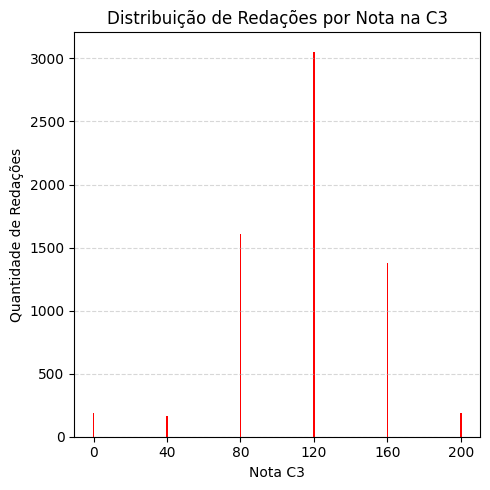

prompt_id                                titulo  \
0          4   Comenta-se que o ex-presidente Lula   
1          6         Amazonas, um bem de todos nós   
2         42  Comprometimento Escolar e Individual   

                                               essay  c1  c2  nota_c3  c4  c5  \
0  ['Comenta-se que o ex presidente Lula ex-presi...   0   0        0   0   0   
1  ['Amazonas, sem ela ele os dias do brasil Bras...   0   0        0   0   0   
2  ['Eu acredito que os dois são muito importante...   0   0        0   0   0   

   score  id                                               tema  \
0      0   4  Um réu deve ou não ser preso após a condenação...   
1      0   6  Preservação da Amazônia: Desafio brasileiro ou...   
2      0  42  O sucesso vem da escola ou do esforço individual?   

                                  textos_motivadores             category  
0  ['No início deste mês de novembro, o Supremo T...  sociedade e cultura  
1  ['No final de agosto passado, as queimadas na ...        meio ambiente  
2  ['De modo geral, não é segredo para ninguém qu...             educação

nota_c3                                             prompt  \
6574      120  Violncia escolar: expor o problema e sugerir s...   
6575       80  Violncia escolar: expor o problema e sugerir s...   
6576      120  Violncia escolar: expor o problema e sugerir s...   

                                              redacao_p  \
6574  [O ambiente escolar se tornou uma vítima da vi...   
6575  [Nos dias atuais é muito comum se deparar com ...   
6576  [Violencia é um problema social que esta cada ...   

                                                redacao  
6574  O ambiente escolar se tornou uma vítima da vio...  
6575  Nos dias atuais é muito comum se deparar com c...  
6576  Violencia é um problema social que esta cada v...

Contagem de valores NaN por coluna:
nota_c3       0
prompt        0
redacao_p     0
redacao      10
dtype: int64
Total de redações com lista vazia: 10


In [3]:
# importação dos dados necessários e tratamentos básicos

df_prompt = pd.read_csv ('data/prompts.csv')
df_essay = pd.read_csv('data/extended_essay-br.csv')

df_essay_prompt = pd.merge(df_essay, df_prompt, left_on = 'prompt', right_on = 'id', how = 'inner')
df_essay_prompt.rename(columns = {'prompt': 'prompt_id', 'title_y': 'tema', 'title_x': 'titulo', 'description': 'textos_motivadores', 'c3': 'nota_c3'}, inplace = True)

contagem_estratificada = df_essay_prompt.groupby(['nota_c3']).size().reset_index(name='count')
plt.figure(figsize = (5, 5))
plt.bar(contagem_estratificada['nota_c3'], contagem_estratificada['count'], color = 'red')
plt.xlabel('Nota C3')
plt.ylabel('Quantidade de Redações')
plt.title('Distribuição de Redações por Nota na C3')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(contagem_estratificada['nota_c3'])
plt.tight_layout()
plt.show()

display(df_essay_prompt.head(3))

df_essay_prompt['prompt'] = df_essay_prompt['tema'].str.strip() + '\n\n' + df_essay_prompt['textos_motivadores'].apply(limpeza_prompt)
df_essay_prompt['redacao_p'] = df_essay_prompt['essay'].apply(limpeza_basica)
df_essay_prompt['redacao'] = df_essay_prompt['redacao_p'].apply(concatenar_paragrafos)

df_essay_prompt.drop(columns = ['c1', 'c2', 'c4', 'c5', 'score', 'category', 'id', 'prompt_id', 'titulo', 'essay', 'tema', 'textos_motivadores'], inplace = True)

display(df_essay_prompt.tail(3))

print("Contagem de valores NaN por coluna:")
print(df_essay_prompt.isna().sum())

df_essay_prompt['lista_vazia'] = df_essay_prompt['redacao_p'].apply(lambda x: isinstance(x, list) and len(x) == 0)

print(f"Total de redações com lista vazia: {df_essay_prompt['lista_vazia'].sum()}")

df_essay_prompt = df_essay_prompt[df_essay_prompt['redacao_p'].apply(lambda x: not (isinstance(x, list) and len(x) == 0))].reset_index(drop = True)

vazios = df_essay_prompt['prompt'].apply(lambda x: isinstance(x, str) and x.strip() == '')



### Extração de Features das Redações

Nesta célula, é realizada a extração das features das redações com base na classe `FeaturesC3V2`. Para evitar retrabalho em execuções futuras, pode-se optar por pular esta etapa caso os dados já tenham sido processados anteriormente.

A instância `features_redacoes` é criada para aplicar o método `extrair_todas_features`, que gera as diversas métricas estruturais, léxicas, sintáticas e semânticas para cada redação. O resultado é armazenado no DataFrame `df_features_redacoes` e salvo em disco no arquivo `df_features_redacoesV0.csv`.


In [15]:
# pular essa célula em caso de execução mais rápida para não refazer a extação de features
df_amostra = df_essay_prompt.copy()
print(df_amostra['nota_c3'].value_counts())

features_redacoes = FeaturesC3V2()

df_features_redacoes = features_redacoes.extrair_todas_features(df_amostra)
display(df_features_redacoes.head(5))

df_features_redacoes.to_csv("data/df_features_redacoesV0.csv", index=False, encoding="utf-8")

nota_c3
120    3050
80     1602
160    1375
200     191
0       185
40      164
Name: count, dtype: int64
Inicializando classe de extração de features...
Inicialização concluída.


Extraindo features de redações: 100%|██████████| 6567/6567 [1:31:01<00:00,  1.20it/s] 


id_redacao  total_sentencas  sentencas_introducao  sentencas_argumentacao  \
0           0                6                     2                       3   
1           1                5                     2                       0   
2           2                7                     7                       0   
3           3                8                     2                       5   
4           4                6                     2                       2   

   sentencas_conclusao  media_palavras_sentenca_com_sw  \
0                    1                           33.17   
1                    3                           28.80   
2                    0                           19.00   
3                    1                           31.12   
4                    2                           34.00   

   media_palavras_sentenca_sem_sw  total_paragrafos  paragrafos_introducao  \
0                           19.83                 5                      1   
1                           13.80                 2                      1   
2                           10.71                 1                      1   
3                           16.12                 6                      1   
4                           21.00                 4                      1   

   paragrafos_argumentacao  ...  n_entidades_total  diversidade_entidades  \
0                        3  ...                 10                      4   
1                        0  ...                  7                      3   
2                        0  ...                  3                      2   
3                        4  ...                  4                      2   
4                        2  ...                  9                      3   

   n_marcadores_exatos  n_marcadores_semanticos  \
0                    5                        0   
1                    7                        0   
2                    3                        0   
3                    3                        0   
4                    8                        0   

   similaridade_sentencas_argumentativas_media  \
0                                       0.7491   
1                                       0.0000   
2                                       0.0000   
3                                       0.7583   
4                                       0.8525   

   similaridade_sentencas_argumentativas_min  \
0                                     0.7245   
1                                     0.0000   
2                                     0.0000   
3                                     0.6979   
4                                     0.8525   

   similaridade_sentencas_argumentativas_max  \
0                                     0.7737   
1                                     0.0000   
2                                     0.0000   
3                                     0.8096   
4                                     0.8525   

   similaridade_sentencas_argumentativas_std  similaridade_redacao_tema  \
0                                     0.0348                     0.8204   
1                                     0.0000                     0.7880   
2                                     0.0000                     0.8518   
3                                     0.0545                     0.8720   
4                                     0.0000                     0.8948   

   nota_c3  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 51 columns]

In [4]:
df_resultado = pd.read_csv ('data/df_features_redacoesV0.csv')

### Análise de Correlação entre Features Numéricas e Nota C3

Nesta célula, selecionamos apenas as colunas de features numéricas do DataFrame `df_resultado`. Garantimos que a coluna `nota_c3` esteja presente para análise de correlação. Em seguida, calculamos a matriz de correlação entre todas as variáveis numéricas.

O foco principal é identificar as features mais correlacionadas com a nota da competência 3 (`nota_c3`). Para isso, extraímos e ordenamos as correlações absolutas em ordem decrescente, descartando a autocorrelação da própria nota.

Por fim, um mapa de calor (heatmap) é plotado para visualizar as correlações entre todas as variáveis numéricas, facilitando a identificação de relações fortes e possíveis padrões entre as features e a nota C3.


:P - :P - :P - :P - :P - :P - :P - :P - :P - :P - 
features mais correlacionadas com a 'nota_c3'
:P - :P - :P - :P - :P - :P - :P - :P - :P - :P - 
<bound method NDFrame.head of                                              correlacao  correlacao_abs
projeto_texto                                  0.986951        0.986951
palavras_unicas_sem_sw                         0.441325        0.441325
palavras_unicas_com_sw                         0.434979        0.434979
total_palavras_sem_sw                          0.434919        0.434919
n_substantivos                                 0.433512        0.433512
n_preposicoes                                  0.428134        0.428134
total_palavras_com_sw                          0.419606        0.419606
n_pontuacoes                                   0.396241        0.396241
n_adjetivos                                    0.384858        0.384858
n_determinantes                                0.359856        0.359856
n_marcadores_exatos           

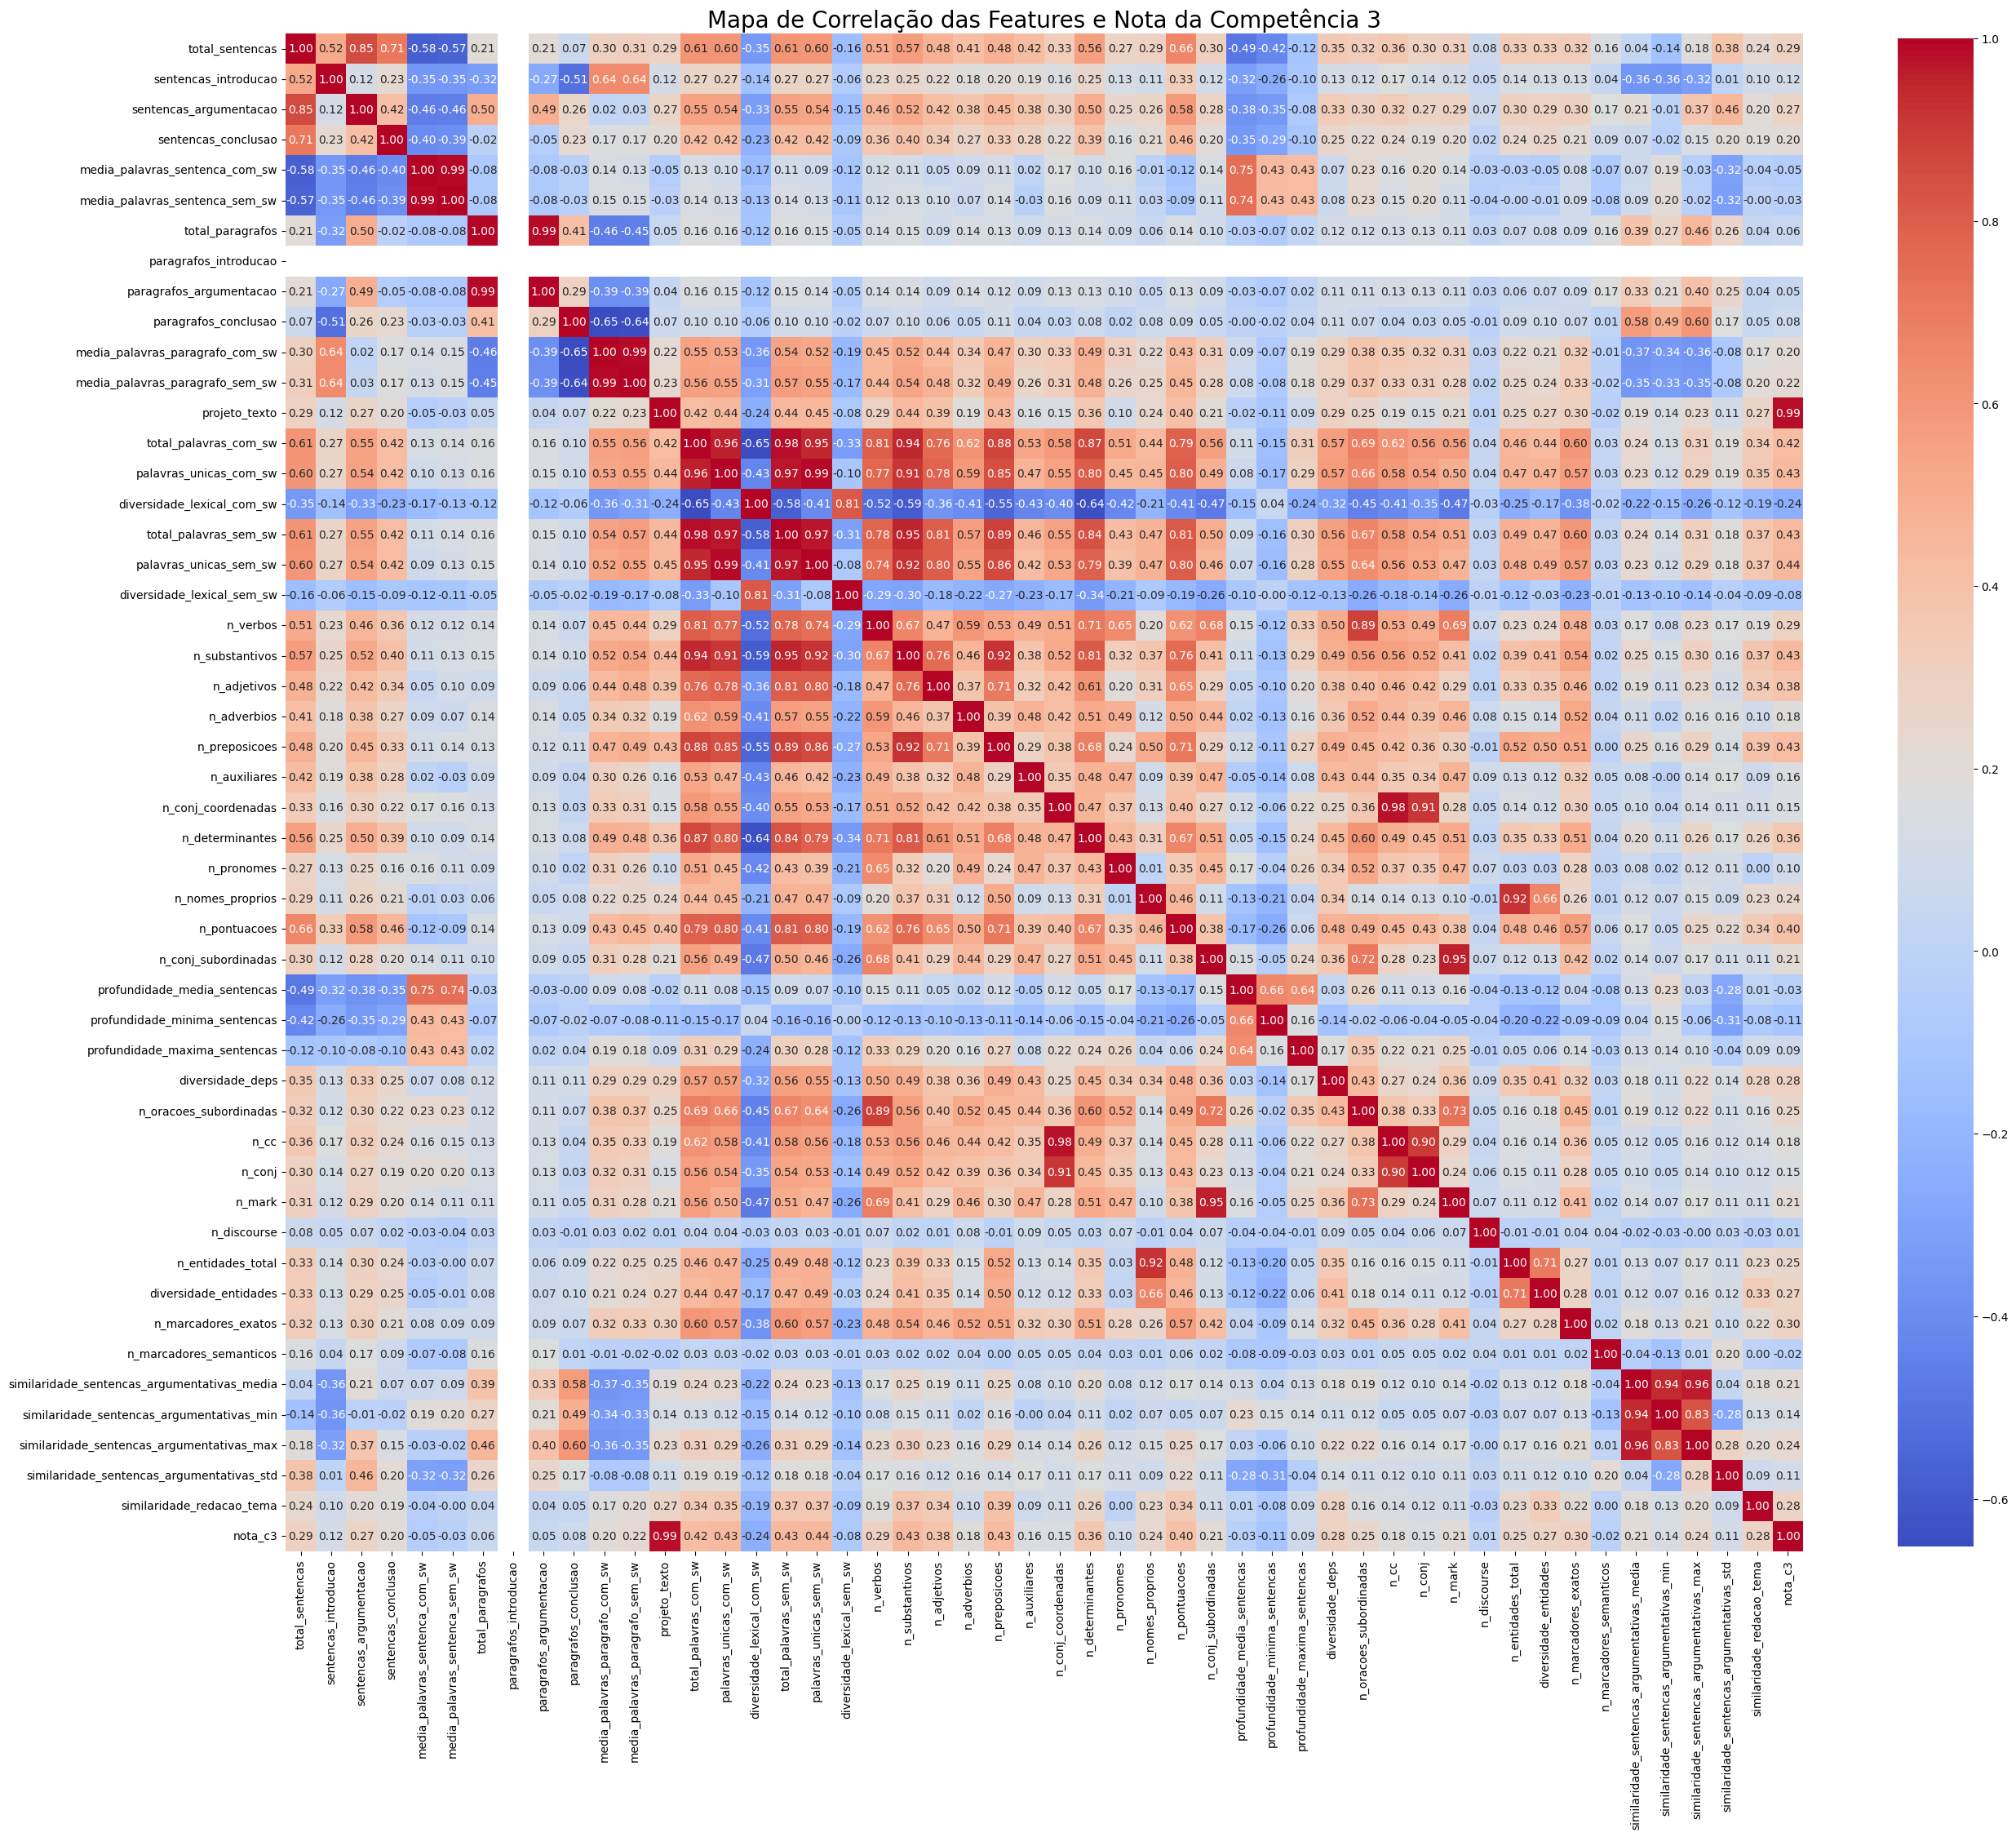

In [5]:
df_numerico = df_resultado.select_dtypes(include='number').drop(columns=['id_redacao'])

# garantir presenca da coluna de nota
if 'nota_c3' not in df_numerico.columns and 'nota_c3' in df_resultado.columns:
    df_numerico['nota_c3'] = df_resultado['nota_c3']


corr_matrix = df_numerico.corr()
print(":P - "*10)
print("features mais correlacionadas com a 'nota_c3'")
print(":P - "*10)

corr_com_nota = corr_matrix['nota_c3'].dropna()

df_corr_nota = pd.DataFrame(corr_com_nota)
df_corr_nota.columns = ['correlacao']
df_corr_nota['correlacao_abs'] = df_corr_nota['correlacao'].abs()

df_corr_ordenada = df_corr_nota.sort_values(by = 'correlacao_abs', ascending = False)
df_corr_ordenada = df_corr_ordenada.drop(index = 'nota_c3')
print(df_corr_ordenada.head)

print("mapa de calor de correlações")

plt.figure(figsize = (30, 30))

sns.heatmap(
    corr_matrix,
    annot = True,   
    fmt = ".2f",   
    cmap = 'coolwarm',
    square = True,
    cbar_kws = {"shrink": .8}
)
plt.title('Mapa de Correlação das Features e Nota da Competência 3', fontsize = 20)
plt.show()


### Otimização e Avaliação de Modelos de Classificação

#### `otimizar_e_treinar_modelos`

Esta função realiza a busca aleatória (`RandomizedSearchCV`) para encontrar os melhores hiperparâmetros dos modelos especificados (Regressão Logística, SVM, Random Forest, Gradient Boosting e XGBoost).  
Recebe os dados de treino e flags para indicar quais modelos treinar.  
Retorna um dicionário com os melhores estimadores encontrados para cada modelo otimizado.

---

#### `avaliar_modelo_classificacao`

Esta função avalia um modelo treinado utilizando o conjunto de teste. Calcula métricas importantes como acurácia, quadratic weighted kappa (QWK), erro absoluto médio (MAE) e raiz do erro quadrático médio (RMSE).  
Exibe o relatório de classificação com os rótulos originais e plota a matriz de confusão.  
Também calcula a importância das features via permutação e apresenta as 10 mais relevantes para a predição do modelo.


In [43]:
# otimizar modelos procurando melhores parametros
def otimizar_e_treinar_modelos(X_train, y_train_encoded, treinar_rl = 1, treinar_svm = 0, treinar_rf = 0, treinar_gbc = 0, treinar_xgb = 0):
    melhores_modelos = {}
    
    # parametros dos modelos
    params = {
        'Regressão Logística': {'model__C': loguniform(1e-2, 1e2)},
        'SVM': {'model__C': loguniform(1e-1, 1e3), 'model__gamma': loguniform(1e-4, 1e-1), 'model__kernel': ['rbf']},
        'Random Forest': {'model__n_estimators': randint(100, 500), 'model__max_depth': [10, 20, 30, None], 'model__min_samples_leaf': randint(1, 5)},
        'Gradient Boosting': {'model__n_estimators': randint(100, 400), 'model__learning_rate': loguniform(1e-3, 1e-1), 'model__max_depth': [3, 5, 7]},
        'XGBoost': {'model__n_estimators': randint(100, 500), 'model__learning_rate': loguniform(1e-3, 1e-1), 'model__max_depth': [3, 5, 7]}
    }
    
    # pipelines dos classificadores
    pipelines = {
        'Regressão Logística': Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(random_state = 42, max_iter = 2000, multi_class = 'ovr'))]),
        'SVM': Pipeline([('scaler', StandardScaler()), ('model', SVC(random_state = 42, probability = True))]),
        'Random Forest': Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(random_state = 42))]),
        'Gradient Boosting': Pipeline([('scaler', StandardScaler()), ('model', GradientBoostingClassifier(random_state = 42))]),
        'XGBoost': Pipeline([('scaler', StandardScaler()), ('model', xgb.XGBClassifier(random_state = 42, use_label_encoder = False, eval_metric = 'mlogloss'))])
    }

    flags = {'Regressão Logística': treinar_rl, 'SVM': treinar_svm, 'Random Forest': treinar_rf, 'Gradient Boosting': treinar_gbc, 'XGBoost': treinar_xgb}
    for nome, pipeline in pipelines.items():
        if flags[nome]:
            print(f"otimizando modelo : {nome}")

            search = RandomizedSearchCV(pipeline, params[nome], n_iter = 15, cv = 5, random_state = 42, n_jobs = -1, scoring = 'f1_weighted', verbose = 1)
            search.fit(X_train, y_train_encoded)
            print(f"os melhores parametros para {nome}: {search.best_params_}")
            melhores_modelos[nome] = search.best_estimator_

    print("\notimização concluída")
    return melhores_modelos

def avaliar_modelo_classificacao(nome, modelo, X_test, y_test_encoded, encoder):
    import pandas as pd
    y_pred_encoded = modelo.predict(X_test)

    y_test_original = encoder.inverse_transform(y_test_encoded)
    y_pred_original = encoder.inverse_transform(y_pred_encoded)
    nomes_classes_originais = encoder.classes_
    
    # métricas de avaliação
    acuracia = accuracy_score(y_test_original, y_pred_original)
    qw_kappa = cohen_kappa_score(y_test_original, y_pred_original, weights='quadratic')
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    
    print("métricas de classificação")
    print(f"acurácia: {acuracia:.4f}")
    print(f"quadratic weighted kappa (QWK): {qw_kappa:.4f}")
    print(f"precisão (macro): {precision_score(y_test_original, y_pred_original, average='macro'):.4f}")
    print(f"recall (macro): {recall_score(y_test_original, y_pred_original, average='macro'):.4f}")
    print(f"f1-score (macro): {f1_score(y_test_original, y_pred_original, average='macro'):.4f}")
    
    print("\nmétricas de magnitude do erro")
    print(f"mae (erro absoluto médio): {mae:.4f} pontos de nota")
    print(f"rmse (raiz do erro quadrático médio): {rmse:.4f} pontos de nota")
    
    print("\nrelatório de classificação (com rótulos originais):")
    print(classification_report(y_test_encoded, y_pred_encoded, target_names=[str(c) for c in nomes_classes_originais], zero_division=0))

    print("\ncalculando a importância das features ...")
    # A importância por permutação pode não funcionar para dict, então cheque
    if not isinstance(modelo, dict):
        result = permutation_importance(
            modelo, X_test, y_test_encoded, n_repeats=10, random_state=42, n_jobs=-1, scoring='accuracy'
        )

        feature_names = X_test.columns

        df_importances = pd.DataFrame(
            {'feature': feature_names, 'importance_mean': result.importances_mean, 'importance_std': result.importances_std}
        )
        df_importances = df_importances.sort_values('importance_mean', ascending=False)
        
        print("\ntop 10 features mais importantes")
        print(df_importances.head(10))
    else:
        print("\nImportância das features não calculada para modelos combinados (dict).")
    
    cm = confusion_matrix(y_test_encoded, y_pred_encoded)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=nomes_classes_originais, yticklabels=nomes_classes_originais)
    plt.title(f'Matriz de Confusão - {nome}', fontsize=10)
    plt.xlabel('Nota Prevista', fontsize=7)
    plt.ylabel('Nota Real', fontsize=7)
    plt.show()


### Treinamento e Avaliação usando Todas as Features

Nesta etapa, os dados são preparados para o treinamento dos modelos. Primeiro, todas as features numéricas são usadas, exceto as colunas `nota_c3` (target) e `id_redacao` (identificador).

O conjunto de dados é dividido em treino (70%), validação (15%) e teste (15%) mantendo a estratificação da variável resposta para preservar a distribuição das notas em cada subconjunto.

As variáveis alvo são codificadas com `LabelEncoder` para uso nos modelos. Em seguida, a função `otimizar_e_treinar_modelos` é chamada para realizar a busca dos melhores parâmetros para todos os cinco modelos (Regressão Logística, SVM, Random Forest, Gradient Boosting e XGBoost).

Por fim, cada modelo otimizado é avaliado no conjunto de teste utilizando métricas e visualizações detalhadas da função `avaliar_modelo_classificacao`.


In [53]:
# abordagem 1 -> usando todas as features
X = df_resultado.drop(columns=['nota_c3', 'id_redacao', 'projeto_texto'])
y = df_resultado['nota_c3']

# definir as proporções
train_size = 0.70
val_size = 0.15
test_size = 0.15

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=train_size, stratify=y, random_state=42
)

val_test_split_ratio = test_size / (val_size + test_size)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=val_test_split_ratio, stratify=y_temp, random_state=42
)

print("distribuição original das notas:")
display(y.value_counts(normalize = True).sort_index())
print("\ndistribuição das notas no conjunto de Treino:")
display(y_train.value_counts(normalize = True).sort_index())
print("\ndistribuição das notas no conjunto de Validação:")
display(y_val.value_counts(normalize = True).sort_index())
print("\ndistribuição das notas no conjunto de Teste:")
display(y_test.value_counts(normalize = True).sort_index())

print(f"\ntamanhos dos conjuntos: treino = {len(X_train)}, validação = {len(X_val)}, teste = {len(X_test)}")

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

modelos_otimizados = otimizar_e_treinar_modelos(
    X_train, 
    y_train_encoded,
    treinar_rl = 1, 
    treinar_svm = 1, 
    treinar_rf = 1, 
    treinar_gbc = 1, 
    treinar_xgb = 1
)




distribuição original das notas:


nota_c3
0      0.028171
40     0.024973
80     0.243947
120    0.464443
160    0.209380
200    0.029085
Name: proportion, dtype: float64


distribuição das notas no conjunto de Treino:


nota_c3
0      0.028068
40     0.025022
80     0.243908
120    0.464534
160    0.209312
200    0.029156
Name: proportion, dtype: float64


distribuição das notas no conjunto de Validação:


nota_c3
0      0.028426
40     0.025381
80     0.243655
120    0.463959
160    0.209137
200    0.029442
Name: proportion, dtype: float64


distribuição das notas no conjunto de Teste:


nota_c3
0      0.028398
40     0.024341
80     0.244422
120    0.464503
160    0.209939
200    0.028398
Name: proportion, dtype: float64


tamanhos dos conjuntos: treino = 4596, validação = 985, teste = 986
otimizando modelo : Regressão Logística
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/li

os melhores parametros para Regressão Logística: {'model__C': np.float64(63.512210106407046)}
otimizando modelo : SVM
Fitting 5 folds for each of 15 candidates, totalling 75 fits
os melhores parametros para SVM: {'model__C': np.float64(84.71801418819973), 'model__gamma': np.float64(0.006251373574521752), 'model__kernel': 'rbf'}
otimizando modelo : Random Forest
Fitting 5 folds for each of 15 candidates, totalling 75 fits
os melhores parametros para Random Forest: {'model__max_depth': None, 'model__min_samples_leaf': 3, 'model__n_estimators': 249}
otimizando modelo : Gradient Boosting
Fitting 5 folds for each of 15 candidates, totalling 75 fits
os melhores parametros para Gradient Boosting: {'model__learning_rate': np.float64(0.029106359131330698), 'model__max_depth': 3, 'model__n_estimators': 120}
otimizando modelo : XGBoost
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode

os melhores parametros para XGBoost: {'model__learning_rate': np.float64(0.00796156607806295), 'model__max_depth': 5, 'model__n_estimators': 487}

otimização concluída


avaliação do modelo Regressão Logística
métricas de classificação
acurácia: 0.5385
quadratic weighted kappa (QWK): 0.3856
precisão (macro): 0.6458
recall (macro): 0.2732
f1-score (macro): 0.2928

métricas de magnitude do erro
mae (erro absoluto médio): 21.9473 pontos de nota
rmse (raiz do erro quadrático médio): 34.4884 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.75      0.11      0.19        28
          40       0.50      0.04      0.08        24
          80       0.51      0.38      0.44       241
         120       0.54      0.84      0.66       458
         160       0.57      0.23      0.33       207
         200       1.00      0.04      0.07        28

    accuracy                           0.54       986
   macro avg       0.65      0.27      0.29       986
weighted avg       0.56      0.54      0.49       986


calculando a importância das features ...

top 10 features mais im

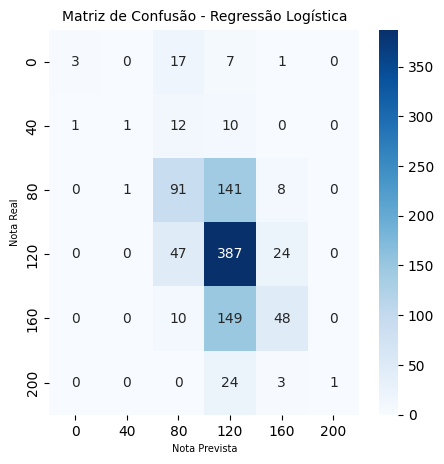

avaliação do modelo SVM
métricas de classificação
acurácia: 0.4878
quadratic weighted kappa (QWK): 0.3680
precisão (macro): 0.3845
recall (macro): 0.2835
f1-score (macro): 0.3046

métricas de magnitude do erro
mae (erro absoluto médio): 24.9899 pontos de nota
rmse (raiz do erro quadrático médio): 37.7888 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.33      0.11      0.16        28
          40       0.17      0.12      0.14        24
          80       0.44      0.37      0.40       241
         120       0.52      0.71      0.60       458
         160       0.47      0.29      0.36       207
         200       0.38      0.11      0.17        28

    accuracy                           0.49       986
   macro avg       0.38      0.28      0.30       986
weighted avg       0.47      0.49      0.46       986


calculando a importância das features ...

top 10 features mais importantes
      

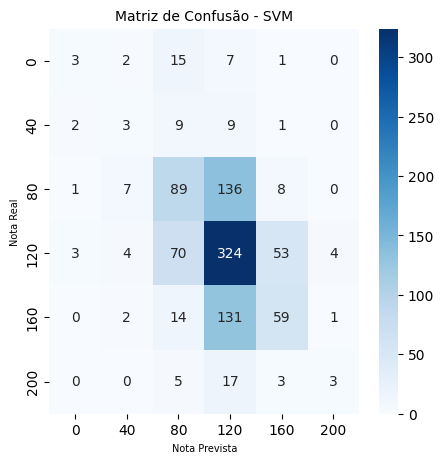

avaliação do modelo Random Forest
métricas de classificação
acurácia: 0.5223
quadratic weighted kappa (QWK): 0.3669
precisão (macro): 0.4256
recall (macro): 0.2496
f1-score (macro): 0.2511

métricas de magnitude do erro
mae (erro absoluto médio): 22.8398 pontos de nota
rmse (raiz do erro quadrático médio): 35.4170 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
          40       1.00      0.04      0.08        24
          80       0.50      0.42      0.46       241
         120       0.53      0.79      0.64       458
         160       0.52      0.25      0.33       207
         200       0.00      0.00      0.00        28

    accuracy                           0.52       986
   macro avg       0.43      0.25      0.25       986
weighted avg       0.50      0.52      0.48       986


calculando a importância das features ...


/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



top 10 features mais importantes
                                        feature  importance_mean  \
4                media_palavras_sentenca_com_sw         0.007099   
11              media_palavras_paragrafo_sem_sw         0.006795   
0                               total_sentencas         0.006389   
28                                 n_pontuacoes         0.006187   
47                    similaridade_redacao_tema         0.006085   
24                           n_conj_coordenadas         0.005882   
10              media_palavras_paragrafo_com_sw         0.005172   
43  similaridade_sentencas_argumentativas_media         0.005071   
34                       n_oracoes_subordinadas         0.005071   
1                          sentencas_introducao         0.004970   

    importance_std  
4         0.003175  
11        0.003850  
0         0.002359  
28        0.004043  
47        0.003713  
24        0.002861  
10        0.003438  
43        0.003333  
34        0.001504  
1      

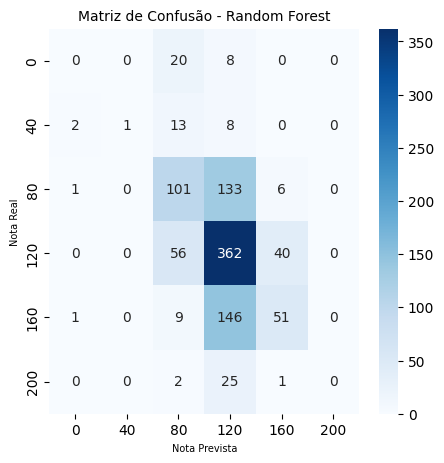

avaliação do modelo Gradient Boosting
métricas de classificação
acurácia: 0.5152
quadratic weighted kappa (QWK): 0.3774
precisão (macro): 0.4064
recall (macro): 0.2688
f1-score (macro): 0.2856

métricas de magnitude do erro
mae (erro absoluto médio): 22.9615 pontos de nota
rmse (raiz do erro quadrático médio): 35.3940 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
          40       0.67      0.17      0.27        24
          80       0.50      0.39      0.44       241
         120       0.52      0.79      0.63       458
         160       0.49      0.23      0.32       207
         200       0.00      0.00      0.00        28

    accuracy                           0.52       986
   macro avg       0.41      0.27      0.29       986
weighted avg       0.49      0.52      0.47       986


calculando a importância das features ...

top 10 features mais impo

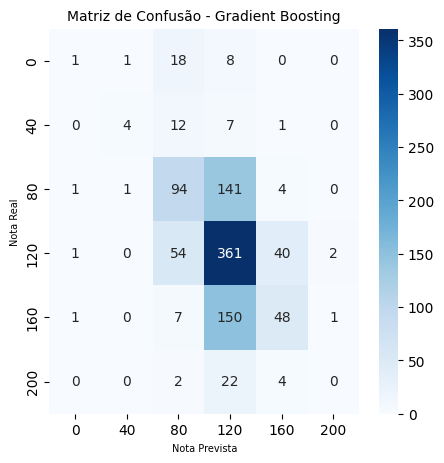

avaliação do modelo XGBoost
métricas de classificação
acurácia: 0.5223
quadratic weighted kappa (QWK): 0.3736
precisão (macro): 0.4090
recall (macro): 0.2747
f1-score (macro): 0.2917

métricas de magnitude do erro
mae (erro absoluto médio): 22.8398 pontos de nota
rmse (raiz do erro quadrático médio): 35.5998 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
          40       0.67      0.17      0.27        24
          80       0.50      0.41      0.45       241
         120       0.53      0.78      0.63       458
         160       0.50      0.25      0.34       207
         200       0.00      0.00      0.00        28

    accuracy                           0.52       986
   macro avg       0.41      0.27      0.29       986
weighted avg       0.50      0.52      0.48       986


calculando a importância das features ...

top 10 features mais importantes
  

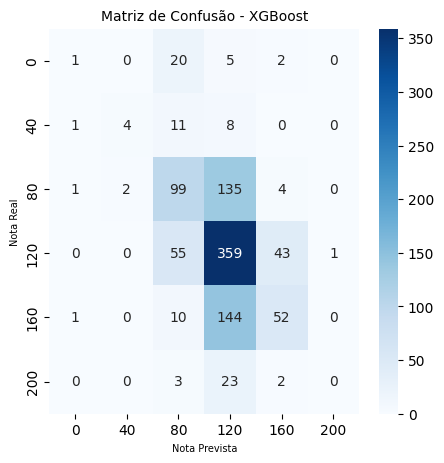

In [44]:
# avaliação de conjunto de teste
for nome, modelo_final in modelos_otimizados.items():
    print(f'avaliação do modelo {nome}')
    avaliar_modelo_classificacao(nome, modelo_final, X_test, y_test_encoded, label_encoder)

avaliação do modelo Regressão Logística
métricas de classificação
acurácia: 0.5188
quadratic weighted kappa (QWK): 0.3223
precisão (macro): 0.3156
recall (macro): 0.2395
f1-score (macro): 0.2368

métricas de magnitude do erro
mae (erro absoluto médio): 23.3503 pontos de nota
rmse (raiz do erro quadrático médio): 36.0710 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.33      0.04      0.06        28
          40       0.00      0.00      0.00        25
          80       0.48      0.37      0.42       240
         120       0.53      0.83      0.65       457
         160       0.55      0.20      0.29       206
         200       0.00      0.00      0.00        29

    accuracy                           0.52       985
   macro avg       0.32      0.24      0.24       985
weighted avg       0.49      0.52      0.46       985


calculando a importância das features ...

top 10 features mais im

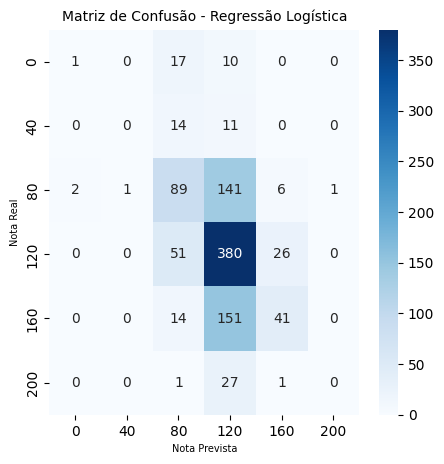

avaliação do modelo SVM
métricas de classificação
acurácia: 0.5127
quadratic weighted kappa (QWK): 0.3412
precisão (macro): 0.3555
recall (macro): 0.3007
f1-score (macro): 0.3146

métricas de magnitude do erro
mae (erro absoluto médio): 24.9340 pontos de nota
rmse (raiz do erro quadrático médio): 39.5713 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.21      0.11      0.14        28
          40       0.28      0.20      0.23        25
          80       0.45      0.43      0.44       240
         120       0.55      0.72      0.63       457
         160       0.52      0.32      0.39       206
         200       0.11      0.03      0.05        29

    accuracy                           0.51       985
   macro avg       0.36      0.30      0.31       985
weighted avg       0.49      0.51      0.49       985


calculando a importância das features ...

top 10 features mais importantes
      

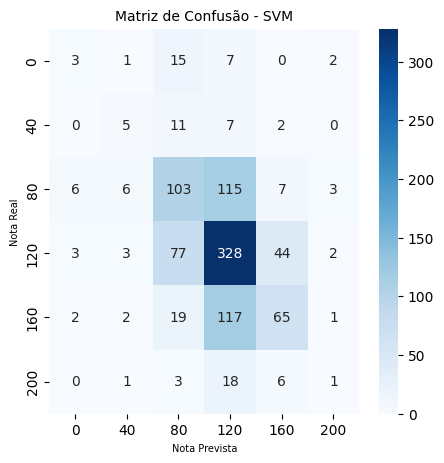

avaliação do modelo Random Forest
métricas de classificação
acurácia: 0.5492
quadratic weighted kappa (QWK): 0.3771
precisão (macro): 0.5198
recall (macro): 0.2881
f1-score (macro): 0.3072

métricas de magnitude do erro
mae (erro absoluto médio): 22.0508 pontos de nota
rmse (raiz do erro quadrático médio): 35.2511 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.67      0.07      0.13        28
          40       0.75      0.12      0.21        25
          80       0.50      0.47      0.49       240
         120       0.55      0.81      0.66       457
         160       0.65      0.25      0.36       206
         200       0.00      0.00      0.00        29

    accuracy                           0.55       985
   macro avg       0.52      0.29      0.31       985
weighted avg       0.55      0.55      0.51       985


calculando a importância das features ...


/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



top 10 features mais importantes
                            feature  importance_mean  importance_std
11  media_palavras_paragrafo_sem_sw         0.012893        0.003907
47        similaridade_redacao_tema         0.010152        0.003575
19                   n_substantivos         0.009543        0.003464
20                      n_adjetivos         0.008731        0.002769
16           palavras_unicas_sem_sw         0.008020        0.002703
28                     n_pontuacoes         0.007716        0.003185
15            total_palavras_sem_sw         0.007716        0.003018
22                    n_preposicoes         0.007208        0.002703
12            total_palavras_com_sw         0.005584        0.002370
0                   total_sentencas         0.005279        0.002350


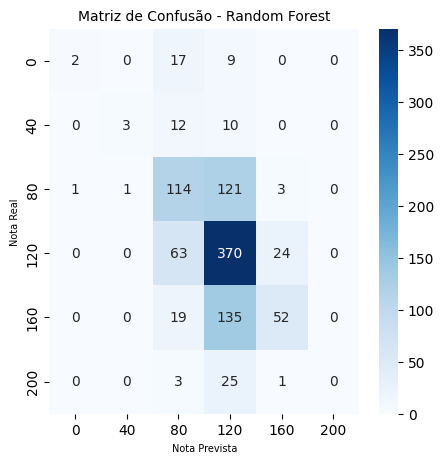

avaliação do modelo Gradient Boosting
métricas de classificação
acurácia: 0.5431
quadratic weighted kappa (QWK): 0.3967
precisão (macro): 0.4657
recall (macro): 0.3185
f1-score (macro): 0.3459

métricas de magnitude do erro
mae (erro absoluto médio): 22.3350 pontos de nota
rmse (raiz do erro quadrático médio): 35.5950 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.50      0.11      0.18        28
          40       0.64      0.28      0.39        25
          80       0.50      0.46      0.48       240
         120       0.55      0.78      0.64       457
         160       0.61      0.29      0.39       206
         200       0.00      0.00      0.00        29

    accuracy                           0.54       985
   macro avg       0.47      0.32      0.35       985
weighted avg       0.53      0.54      0.51       985


calculando a importância das features ...


/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



top 10 features mais importantes
                            feature  importance_mean  importance_std
28                     n_pontuacoes         0.028122        0.007093
11  media_palavras_paragrafo_sem_sw         0.018680        0.005527
12            total_palavras_com_sw         0.015431        0.004206
16           palavras_unicas_sem_sw         0.010761        0.004141
41              n_marcadores_exatos         0.010355        0.004581
19                   n_substantivos         0.009036        0.005569
0                   total_sentencas         0.007817        0.002764
47        similaridade_redacao_tema         0.006904        0.004444
10  media_palavras_paragrafo_com_sw         0.006701        0.003666
20                      n_adjetivos         0.006396        0.004356


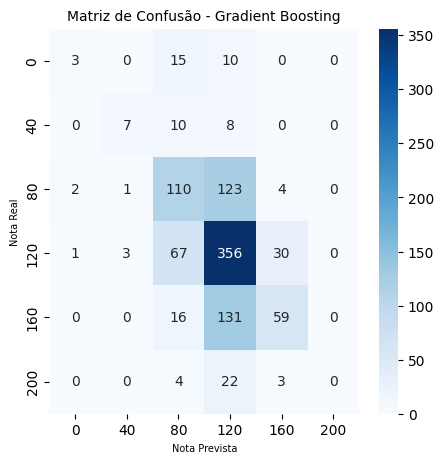

avaliação do modelo XGBoost
métricas de classificação
acurácia: 0.5320
quadratic weighted kappa (QWK): 0.4048
precisão (macro): 0.4972
recall (macro): 0.2943
f1-score (macro): 0.3180

métricas de magnitude do erro
mae (erro absoluto médio): 22.2944 pontos de nota
rmse (raiz do erro quadrático médio): 34.8339 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.67      0.07      0.13        28
          40       0.71      0.20      0.31        25
          80       0.49      0.47      0.48       240
         120       0.54      0.77      0.63       457
         160       0.58      0.26      0.36       206
         200       0.00      0.00      0.00        29

    accuracy                           0.53       985
   macro avg       0.50      0.29      0.32       985
weighted avg       0.53      0.53      0.50       985


calculando a importância das features ...


/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



top 10 features mais importantes
                                      feature  importance_mean  importance_std
11            media_palavras_paragrafo_sem_sw         0.014315        0.006476
12                      total_palavras_com_sw         0.009543        0.005906
44  similaridade_sentencas_argumentativas_min         0.005990        0.002815
16                     palavras_unicas_sem_sw         0.004975        0.004550
45  similaridade_sentencas_argumentativas_max         0.004873        0.002791
17                 diversidade_lexical_sem_sw         0.004264        0.002791
14                 diversidade_lexical_com_sw         0.003046        0.002445
30               profundidade_media_sentencas         0.002944        0.002103
1                        sentencas_introducao         0.002843        0.002754
26                                 n_pronomes         0.002843        0.001861


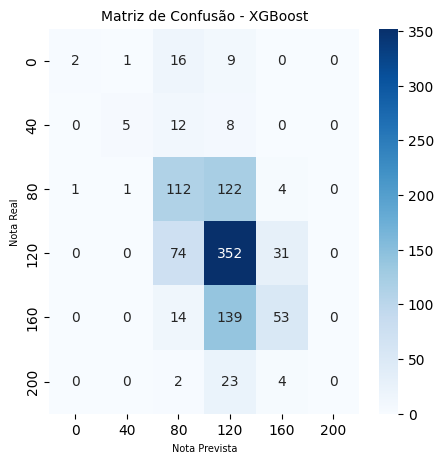

In [48]:
# avaliação de conjunto de validação
for nome, modelo_final in modelos_otimizados.items():
    print(f'avaliação do modelo {nome}')
    avaliar_modelo_classificacao(nome, modelo_final, X_val, y_val_encoded, label_encoder)

### Abordagem 2: Treinamento com as 10 Features mais Correlacionadas

Nesta abordagem, selecionamos amostras estratificadas do DataFrame original, limitando para 150 redações por nota da C3, para garantir equilíbrio.

Trabalhamos com as 10 features numéricas que apresentaram maior correlação absoluta com a nota C3, incluindo contagens de palavras, classes gramaticais e marcadores argumentativos.

Os dados são divididos em treino (70%), validação (15%) e teste (15%) mantendo a estratificação da nota. Em seguida, as labels são codificadas para uso nos modelos.

A função de otimização é chamada para ajustar e treinar cinco modelos clássicos: Regressão Logística, SVM, Random Forest, Gradient Boosting e XGBoost.

Por fim, cada modelo otimizado é avaliado no conjunto de teste com métricas de desempenho e análise da importância das features.


In [50]:
# abordagem 2 -> usando as 10 features com correlação aproximada maior
print("Contagem de amostras por nota no DataFrame ORIGINAL:")
print(df_resultado['nota_c3'].value_counts().sort_index())

df_features_redacoes_2 = (df_resultado
                          .groupby('nota_c3')
                          .sample(150, random_state = 42))
print("amostras no df da abordagem 2:")
print(df_features_redacoes_2['nota_c3'].value_counts().sort_index())

df_features_redacoes_2 = (df_features_redacoes_2[['nota_c3', 
                                                  'palavras_unicas_sem_sw', 'palavras_unicas_com_sw','total_palavras_sem_sw',
                                                  'n_substantivos', 'n_preposicoes', 'total_palavras_com_sw', 
                                                  'n_pontuacoes', 'n_adjetivos','n_determinantes', 
                                                  'n_marcadores_exatos', 'total_sentencas', 'n_verbos',
                                                  'diversidade_deps', 'similaridade_redacao_tema', 'diversidade_entidades']])

X2 = df_features_redacoes_2.drop(columns = ['nota_c3'])
y2 = df_features_redacoes_2['nota_c3']

train_size = 0.70
val_size = 0.15
test_size = 0.15

X_train2, X_temp2, y_train2, y_temp2 = train_test_split(
    X2, y2, train_size = train_size, stratify = y2, random_state = 42
)

val_test_split_ratio = test_size / (val_size + test_size)

X_val2, X_test2, y_val2, y_test2 = train_test_split(
    X_temp2, y_temp2, test_size = val_test_split_ratio, stratify = y_temp2, random_state = 42
)


label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_encoded2 = label_encoder.transform(y_train2)
y_test_encoded2 = label_encoder.transform(y_test2)
y_val_encoded2 = label_encoder.transform(y_val2)

modelos_otimizados2 = otimizar_e_treinar_modelos(
    X_train2, 
    y_train_encoded2,
    treinar_rl = 1, 
    treinar_svm = 1, 
    treinar_rf = 1, 
    treinar_gbc = 1, 
    treinar_xgb = 1
)




Contagem de amostras por nota no DataFrame ORIGINAL:
nota_c3
0       185
40      164
80     1602
120    3050
160    1375
200     191
Name: count, dtype: int64
amostras no df da abordagem 2:
nota_c3
0      150
40     150
80     150
120    150
160    150
200    150
Name: count, dtype: int64
otimizando modelo : Regressão Logística
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/sklearn/li

os melhores parametros para Regressão Logística: {'model__C': np.float64(0.04207988669606638)}
otimizando modelo : SVM
Fitting 5 folds for each of 15 candidates, totalling 75 fits
os melhores parametros para SVM: {'model__C': np.float64(3.14891164795686), 'model__gamma': np.float64(0.07114476009343425), 'model__kernel': 'rbf'}
otimizando modelo : Random Forest
Fitting 5 folds for each of 15 candidates, totalling 75 fits
os melhores parametros para Random Forest: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__n_estimators': 335}
otimizando modelo : Gradient Boosting
Fitting 5 folds for each of 15 candidates, totalling 75 fits
os melhores parametros para Gradient Boosting: {'model__learning_rate': np.float64(0.007309539835912915), 'model__max_depth': 3, 'model__n_estimators': 158}
otimizando modelo : XGBoost
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/Desktop/CC/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode

os melhores parametros para XGBoost: {'model__learning_rate': np.float64(0.0013066739238053278), 'model__max_depth': 3, 'model__n_estimators': 199}

otimização concluída


avaliação do modelo Regressão Logística
métricas de classificação
acurácia: 0.3407
quadratic weighted kappa (QWK): 0.5641
precisão (macro): 0.3214
recall (macro): 0.3429
f1-score (macro): 0.3220

métricas de magnitude do erro
mae (erro absoluto médio): 48.0000 pontos de nota
rmse (raiz do erro quadrático médio): 67.2860 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.38      0.68      0.49        22
          40       0.29      0.27      0.28        22
          80       0.18      0.09      0.12        23
         120       0.43      0.39      0.41        23
         160       0.30      0.26      0.28        23
         200       0.35      0.36      0.36        22

    accuracy                           0.34       135
   macro avg       0.32      0.34      0.32       135
weighted avg       0.32      0.34      0.32       135


calculando a importância das features ...

top 10 features mais im

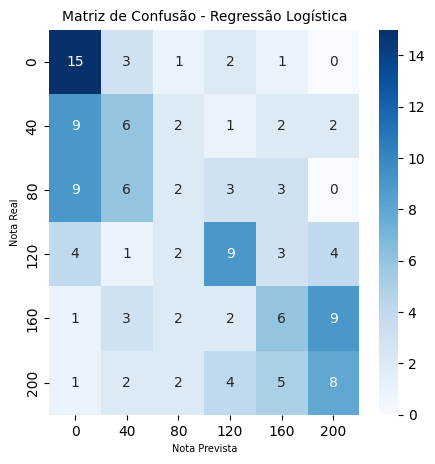

avaliação do modelo SVM
métricas de classificação
acurácia: 0.3037
quadratic weighted kappa (QWK): 0.5858
precisão (macro): 0.3097
recall (macro): 0.3043
f1-score (macro): 0.3003

métricas de magnitude do erro
mae (erro absoluto médio): 46.8148 pontos de nota
rmse (raiz do erro quadrático médio): 62.3491 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.39      0.55      0.45        22
          40       0.46      0.27      0.34        22
          80       0.30      0.30      0.30        23
         120       0.22      0.26      0.24        23
         160       0.27      0.26      0.27        23
         200       0.21      0.18      0.20        22

    accuracy                           0.30       135
   macro avg       0.31      0.30      0.30       135
weighted avg       0.31      0.30      0.30       135


calculando a importância das features ...

top 10 features mais importantes
      

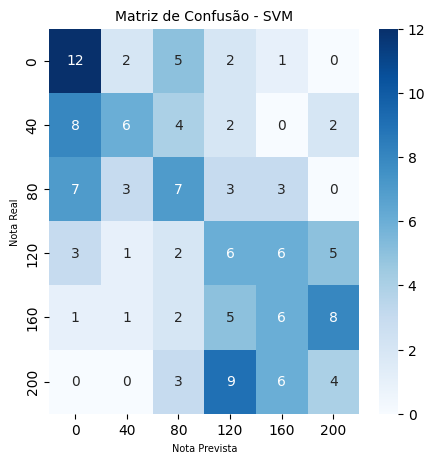

avaliação do modelo Random Forest
métricas de classificação
acurácia: 0.3556
quadratic weighted kappa (QWK): 0.5514
precisão (macro): 0.3583
recall (macro): 0.3557
f1-score (macro): 0.3501

métricas de magnitude do erro
mae (erro absoluto médio): 46.8148 pontos de nota
rmse (raiz do erro quadrático médio): 66.3995 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.39      0.50      0.44        22
          40       0.42      0.23      0.29        22
          80       0.29      0.30      0.30        23
         120       0.26      0.22      0.24        23
         160       0.50      0.52      0.51        23
         200       0.29      0.36      0.32        22

    accuracy                           0.36       135
   macro avg       0.36      0.36      0.35       135
weighted avg       0.36      0.36      0.35       135


calculando a importância das features ...

top 10 features mais importan

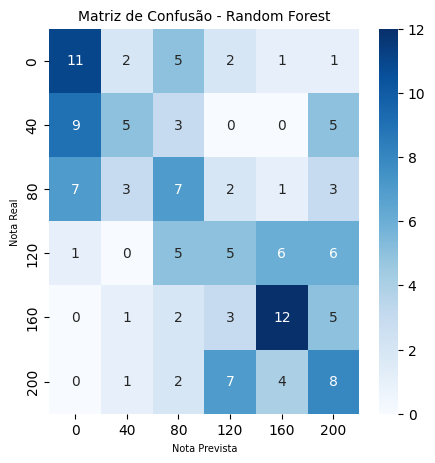

avaliação do modelo Gradient Boosting
métricas de classificação
acurácia: 0.2963
quadratic weighted kappa (QWK): 0.5426
precisão (macro): 0.2981
recall (macro): 0.2974
f1-score (macro): 0.2875

métricas de magnitude do erro
mae (erro absoluto médio): 50.6667 pontos de nota
rmse (raiz do erro quadrático médio): 69.1108 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.30      0.45      0.36        22
          40       0.31      0.18      0.23        22
          80       0.31      0.17      0.22        23
         120       0.30      0.26      0.28        23
         160       0.28      0.30      0.29        23
         200       0.29      0.41      0.34        22

    accuracy                           0.30       135
   macro avg       0.30      0.30      0.29       135
weighted avg       0.30      0.30      0.29       135


calculando a importância das features ...

top 10 features mais impo

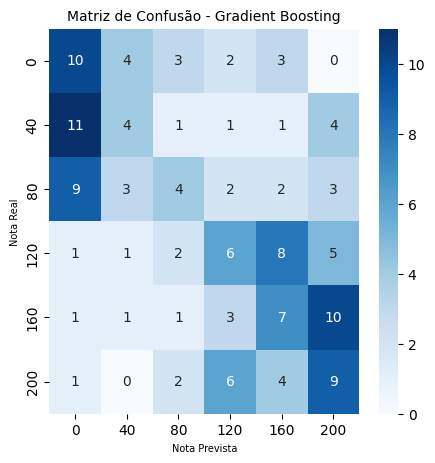

avaliação do modelo XGBoost
métricas de classificação
acurácia: 0.2963
quadratic weighted kappa (QWK): 0.4870
precisão (macro): 0.3011
recall (macro): 0.2978
f1-score (macro): 0.2932

métricas de magnitude do erro
mae (erro absoluto médio): 52.7407 pontos de nota
rmse (raiz do erro quadrático médio): 72.8672 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.30      0.41      0.35        22
          40       0.35      0.32      0.33        22
          80       0.20      0.13      0.16        23
         120       0.44      0.30      0.36        23
         160       0.26      0.26      0.26        23
         200       0.26      0.36      0.30        22

    accuracy                           0.30       135
   macro avg       0.30      0.30      0.29       135
weighted avg       0.30      0.30      0.29       135


calculando a importância das features ...

top 10 features mais importantes
  

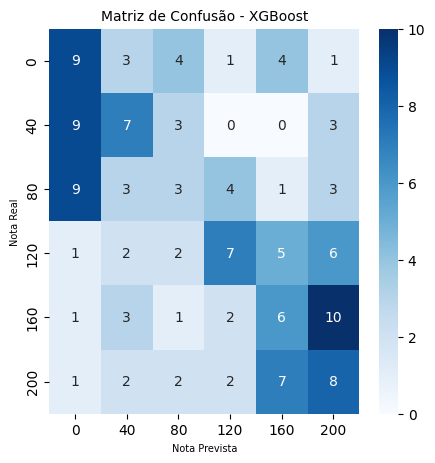

In [47]:
# conjunto teste
for nome, modelo_final in modelos_otimizados2.items():
    print(f'avaliação do modelo {nome}')
    avaliar_modelo_classificacao(nome, modelo_final, X_test2, y_test_encoded2, label_encoder)

avaliação do modelo Regressão Logística
métricas de classificação
acurácia: 0.3185
quadratic weighted kappa (QWK): 0.5229
precisão (macro): 0.2908
recall (macro): 0.3162
f1-score (macro): 0.2982

métricas de magnitude do erro
mae (erro absoluto médio): 50.3704 pontos de nota
rmse (raiz do erro quadrático médio): 69.5382 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.50      0.61      0.55        23
          40       0.30      0.39      0.34        23
          80       0.12      0.05      0.07        22
         120       0.25      0.23      0.24        22
         160       0.32      0.36      0.34        22
         200       0.25      0.26      0.26        23

    accuracy                           0.32       135
   macro avg       0.29      0.32      0.30       135
weighted avg       0.29      0.32      0.30       135


calculando a importância das features ...

top 10 features mais im

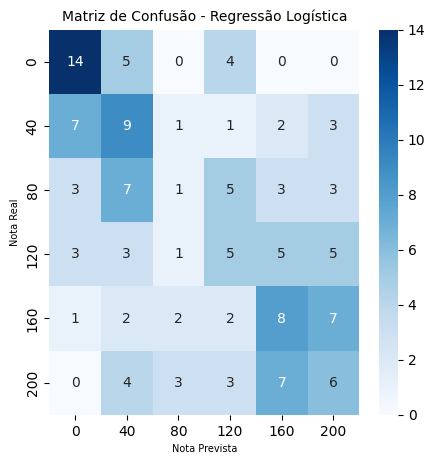

avaliação do modelo SVM
métricas de classificação
acurácia: 0.3481
quadratic weighted kappa (QWK): 0.4820
precisão (macro): 0.3544
recall (macro): 0.3475
f1-score (macro): 0.3429

métricas de magnitude do erro
mae (erro absoluto médio): 49.1852 pontos de nota
rmse (raiz do erro quadrático médio): 69.8782 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.39      0.48      0.43        23
          40       0.50      0.39      0.44        23
          80       0.29      0.18      0.22        22
         120       0.25      0.32      0.28        22
         160       0.32      0.45      0.38        22
         200       0.38      0.26      0.31        23

    accuracy                           0.35       135
   macro avg       0.35      0.35      0.34       135
weighted avg       0.36      0.35      0.34       135


calculando a importância das features ...

top 10 features mais importantes
      

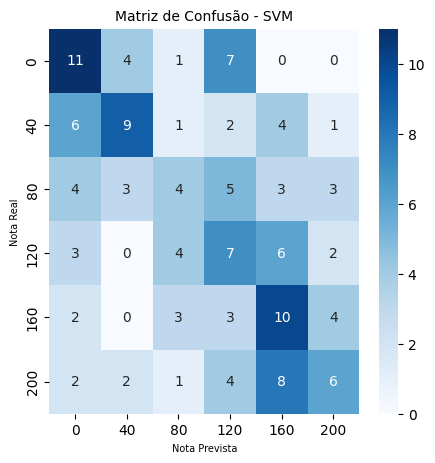

avaliação do modelo Random Forest
métricas de classificação
acurácia: 0.3407
quadratic weighted kappa (QWK): 0.5313
precisão (macro): 0.3453
recall (macro): 0.3386
f1-score (macro): 0.3383

métricas de magnitude do erro
mae (erro absoluto médio): 47.7037 pontos de nota
rmse (raiz do erro quadrático médio): 67.8997 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.50      0.57      0.53        23
          40       0.56      0.39      0.46        23
          80       0.17      0.14      0.15        22
         120       0.30      0.32      0.31        22
         160       0.23      0.27      0.25        22
         200       0.31      0.35      0.33        23

    accuracy                           0.34       135
   macro avg       0.35      0.34      0.34       135
weighted avg       0.35      0.34      0.34       135


calculando a importância das features ...

top 10 features mais importan

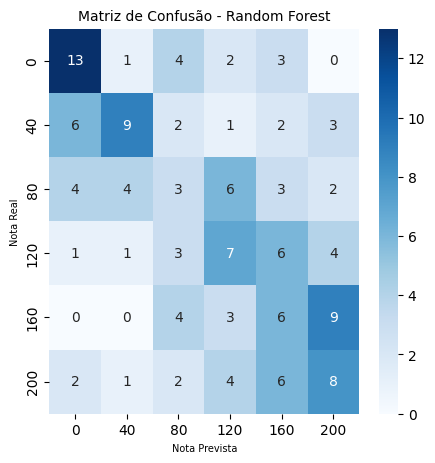

avaliação do modelo Gradient Boosting
métricas de classificação
acurácia: 0.3037
quadratic weighted kappa (QWK): 0.4421
precisão (macro): 0.2940
recall (macro): 0.3020
f1-score (macro): 0.2920

métricas de magnitude do erro
mae (erro absoluto médio): 54.2222 pontos de nota
rmse (raiz do erro quadrático médio): 74.2369 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.42      0.57      0.48        23
          40       0.47      0.30      0.37        23
          80       0.07      0.05      0.06        22
         120       0.24      0.32      0.27        22
         160       0.30      0.32      0.31        22
         200       0.26      0.26      0.26        23

    accuracy                           0.30       135
   macro avg       0.29      0.30      0.29       135
weighted avg       0.30      0.30      0.29       135


calculando a importância das features ...

top 10 features mais impo

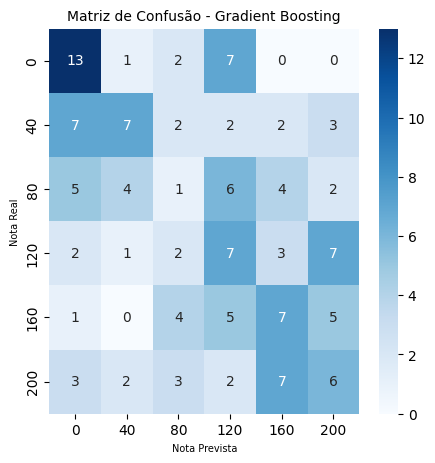

avaliação do modelo XGBoost
métricas de classificação
acurácia: 0.3111
quadratic weighted kappa (QWK): 0.4726
precisão (macro): 0.3006
recall (macro): 0.3090
f1-score (macro): 0.3012

métricas de magnitude do erro
mae (erro absoluto médio): 51.8519 pontos de nota
rmse (raiz do erro quadrático médio): 72.7858 pontos de nota

relatório de classificação (com rótulos originais):
              precision    recall  f1-score   support

           0       0.43      0.52      0.47        23
          40       0.50      0.43      0.47        23
          80       0.15      0.09      0.11        22
         120       0.30      0.36      0.33        22
         160       0.21      0.18      0.20        22
         200       0.21      0.26      0.24        23

    accuracy                           0.31       135
   macro avg       0.30      0.31      0.30       135
weighted avg       0.30      0.31      0.30       135


calculando a importância das features ...

top 10 features mais importantes
  

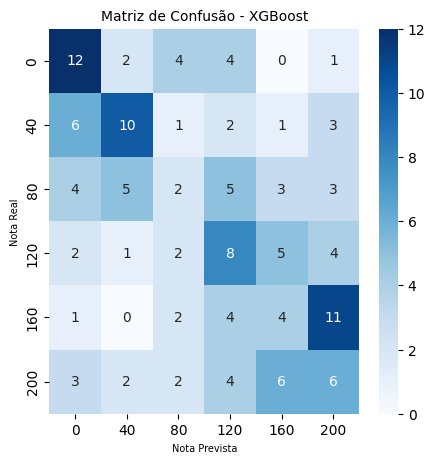

In [46]:
# conjunto validacao
for nome, modelo_final in modelos_otimizados2.items():
    print(f'avaliação do modelo {nome}')
    avaliar_modelo_classificacao(nome, modelo_final, X_val2, y_val_encoded2, label_encoder)

In [25]:
df_analise = df_resultado.drop(columns= ['id_redacao'])

df_analise_c3_0 = df_analise[df_analise['nota_c3'] == 0]
#display(df_analise_c3_0[['nota_c3', 'palavras_unicas_sem_sw', 'palavras_unicas_com_sw','total_palavras_sem_sw', 'n_substantivos', 'n_preposicoes','total_palavras_com_sw', 'n_pontuacoes', 'n_adjetivos','n_determinantes', 'n_marcadores_exatos', 'total_sentencas']].head(3))
display(df_analise_c3_0[['nota_c3',
    'palavras_unicas_sem_sw', 'palavras_unicas_com_sw', 'total_palavras_sem_sw',
    'n_substantivos', 'n_preposicoes', 'total_palavras_com_sw',
    'n_pontuacoes', 'n_adjetivos', 'n_determinantes',
    'n_marcadores_exatos', 'total_sentencas', 'n_verbos',
    'diversidade_deps', 'similaridade_redacao_tema', 'diversidade_entidades']].describe())

df_analise_c3_40 = df_analise[df_analise['nota_c3'] == 40]
display(df_analise_c3_40[['nota_c3',
    'palavras_unicas_sem_sw', 'palavras_unicas_com_sw', 'total_palavras_sem_sw',
    'n_substantivos', 'n_preposicoes', 'total_palavras_com_sw',
    'n_pontuacoes', 'n_adjetivos', 'n_determinantes',
    'n_marcadores_exatos', 'total_sentencas', 'n_verbos',
    'diversidade_deps', 'similaridade_redacao_tema', 'diversidade_entidades']].describe())

df_analise_c3_80 = df_analise[df_analise['nota_c3'] == 80]
display(df_analise_c3_80[['nota_c3',
    'palavras_unicas_sem_sw', 'palavras_unicas_com_sw', 'total_palavras_sem_sw',
    'n_substantivos', 'n_preposicoes', 'total_palavras_com_sw',
    'n_pontuacoes', 'n_adjetivos', 'n_determinantes',
    'n_marcadores_exatos', 'total_sentencas', 'n_verbos',
    'diversidade_deps', 'similaridade_redacao_tema', 'diversidade_entidades']].describe())

df_analise_c3_120 = df_analise[df_analise['nota_c3'] == 120]
display(df_analise_c3_120[['nota_c3',
    'palavras_unicas_sem_sw', 'palavras_unicas_com_sw', 'total_palavras_sem_sw',
    'n_substantivos', 'n_preposicoes', 'total_palavras_com_sw',
    'n_pontuacoes', 'n_adjetivos', 'n_determinantes',
    'n_marcadores_exatos', 'total_sentencas', 'n_verbos',
    'diversidade_deps', 'similaridade_redacao_tema', 'diversidade_entidades']].describe())

df_analise_c3_160 = df_analise[df_analise['nota_c3'] == 160]
display(df_analise_c3_160[['nota_c3',
    'palavras_unicas_sem_sw', 'palavras_unicas_com_sw', 'total_palavras_sem_sw',
    'n_substantivos', 'n_preposicoes', 'total_palavras_com_sw',
    'n_pontuacoes', 'n_adjetivos', 'n_determinantes',
    'n_marcadores_exatos', 'total_sentencas', 'n_verbos',
    'diversidade_deps', 'similaridade_redacao_tema', 'diversidade_entidades']].describe())

df_analise_c3_200 = df_analise[df_analise['nota_c3'] == 200]
display(df_analise_c3_200[['nota_c3',
    'palavras_unicas_sem_sw', 'palavras_unicas_com_sw', 'total_palavras_sem_sw',
    'n_substantivos', 'n_preposicoes', 'total_palavras_com_sw',
    'n_pontuacoes', 'n_adjetivos', 'n_determinantes',
    'n_marcadores_exatos', 'total_sentencas', 'n_verbos',
    'diversidade_deps', 'similaridade_redacao_tema', 'diversidade_entidades']].describe())

nota_c3  palavras_unicas_sem_sw  palavras_unicas_com_sw  \
count    185.0               185.00000              185.000000   
mean       0.0                94.40000              128.497297   
std        0.0                29.30299               34.032134   
min        0.0                35.00000               51.000000   
25%        0.0                74.00000              107.000000   
50%        0.0                94.00000              128.000000   
75%        0.0               109.00000              145.000000   
max        0.0               203.00000              263.000000   

       total_palavras_sem_sw  n_substantivos  n_preposicoes  \
count             185.000000      185.000000     185.000000   
mean              112.681081       51.729730      31.756757   
std                35.401285       18.068482      13.179376   
min                38.000000       16.000000       7.000000   
25%                88.000000       40.000000      22.000000   
50%               110.000000       50.000000      29.000000   
75%               133.000000       62.000000      38.000000   
max               239.000000      138.000000      95.000000   

       total_palavras_com_sw  n_pontuacoes  n_adjetivos  n_determinantes  \
count             185.000000    185.000000   185.000000       185.000000   
mean              205.459459     23.600000    15.205405        25.848649   
std                63.381091     10.689898     7.526834         9.020436   
min                71.000000      4.000000     3.000000         5.000000   
25%               163.000000     17.000000    10.000000        19.000000   
50%               198.000000     21.000000    14.000000        26.000000   
75%               246.000000     30.000000    19.000000        31.000000   
max               444.000000     57.000000    37.000000        55.000000   

       n_marcadores_exatos  total_sentencas    n_verbos  diversidade_deps  \
count           185.000000       185.000000  185.000000        185.000000   
mean              6.027027         7.540541   28.448649         26.135135   
std               3.225969         3.366996    9.458077          2.460141   
min               0.000000         1.000000    4.000000         19.000000   
25%               4.000000         5.000000   22.000000         25.000000   
50%               5.000000         7.000000   28.000000         26.000000   
75%               8.000000         9.000000   34.000000         28.000000   
max              16.000000        25.000000   63.000000         33.000000   

       similaridade_redacao_tema  diversidade_entidades  
count                 185.000000             185.000000  
mean                    0.856663               1.545946  
std                     0.049566               1.078091  
min                     0.748600               0.000000  
25%                     0.819200               1.000000  
50%                     0.858200               1.000000  
75%                     0.900200               2.000000  
max                     0.947300               4.000000

nota_c3  palavras_unicas_sem_sw  palavras_unicas_com_sw  \
count    164.0              164.000000              164.000000   
mean      40.0               97.292683              130.682927   
std        0.0               43.048835               50.577979   
min       40.0               35.000000               56.000000   
25%       40.0               66.000000               95.000000   
50%       40.0               87.500000              120.500000   
75%       40.0              119.250000              154.000000   
max       40.0              311.000000              388.000000   

       total_palavras_sem_sw  n_substantivos  n_preposicoes  \
count             164.000000      164.000000     164.000000   
mean              117.487805       54.853659      33.304878   
std                55.850314       26.625382      17.020514   
min                41.000000       17.000000       9.000000   
25%                77.000000       36.750000      21.000000   
50%               103.000000       48.000000      29.000000   
75%               145.500000       70.000000      43.250000   
max               428.000000      200.000000     132.000000   

       total_palavras_com_sw  n_pontuacoes  n_adjetivos  n_determinantes  \
count             164.000000    164.000000   164.000000       164.000000   
mean              209.939024     25.493902    15.878049        25.628049   
std               105.797393     14.797818     9.365634        13.160247   
min                72.000000      6.000000     2.000000         6.000000   
25%               137.750000     14.750000     9.000000        16.750000   
50%               186.000000     23.500000    13.000000        23.000000   
75%               255.500000     31.250000    22.000000        32.250000   
max               917.000000     96.000000    48.000000       106.000000   

       n_marcadores_exatos  total_sentencas    n_verbos  diversidade_deps  \
count           164.000000       164.000000  164.000000        164.000000   
mean              5.792683         8.756098   28.408537         25.823171   
std               3.959109         6.453345   15.663178          2.903216   
min               0.000000         1.000000    9.000000         18.000000   
25%               3.000000         5.000000   17.000000         24.000000   
50%               5.000000         7.000000   26.000000         26.000000   
75%               7.000000        11.000000   35.000000         28.000000   
max              28.000000        46.000000  136.000000         31.000000   

       similaridade_redacao_tema  diversidade_entidades  
count                 164.000000             164.000000  
mean                    0.883536               1.810976  
std                     0.046970               1.201074  
min                     0.565400               0.000000  
25%                     0.859400               1.000000  
50%                     0.885550               2.000000  
75%                     0.912950               3.000000  
max                     0.956900               4.000000

nota_c3  palavras_unicas_sem_sw  palavras_unicas_com_sw  \
count   1602.0             1602.000000             1602.000000   
mean      80.0              111.455680              147.770287   
std        0.0               34.169319               38.793657   
min       80.0               36.000000               54.000000   
25%       80.0               87.000000              121.000000   
50%       80.0              106.000000              142.000000   
75%       80.0              131.000000              170.000000   
max       80.0              286.000000              337.000000   

       total_palavras_sem_sw  n_substantivos  n_preposicoes  \
count            1602.000000     1602.000000    1602.000000   
mean              134.511236       62.696005      39.192260   
std                43.522323       20.993604      15.087022   
min                40.000000        4.000000      10.000000   
25%               103.000000       47.000000      28.000000   
50%               127.000000       60.000000      37.000000   
75%               158.000000       75.000000      48.000000   
max               361.000000      173.000000     110.000000   

       total_palavras_com_sw  n_pontuacoes  n_adjetivos  n_determinantes  \
count            1602.000000   1602.000000  1602.000000      1602.000000   
mean              241.878901     28.838951    18.760300        30.155431   
std                77.824225     12.202294     8.247573        10.697426   
min                67.000000      5.000000     0.000000         8.000000   
25%               186.000000     21.000000    13.000000        22.000000   
50%               227.000000     27.000000    17.000000        29.000000   
75%               284.000000     35.000000    23.000000        36.000000   
max               650.000000    109.000000    63.000000        85.000000   

       n_marcadores_exatos  total_sentencas     n_verbos  diversidade_deps  \
count          1602.000000      1602.000000  1602.000000       1602.000000   
mean              6.838951         9.462547    32.144819         26.879526   
std               3.779564         4.820206    12.003653          2.252869   
min               0.000000         2.000000     7.000000         17.000000   
25%               4.000000         6.000000    24.000000         25.000000   
50%               6.000000         9.000000    30.000000         27.000000   
75%               9.000000        11.000000    39.000000         28.000000   
max              29.000000        47.000000    95.000000         33.000000   

       similaridade_redacao_tema  diversidade_entidades  
count                1602.000000            1602.000000  
mean                    0.890655               1.971910  
std                     0.046403               1.131497  
min                     0.647400               0.000000  
25%                     0.866225               1.000000  
50%                     0.904800               2.000000  
75%                     0.924975               3.000000  
max                     0.968500               4.000000

nota_c3  palavras_unicas_sem_sw  palavras_unicas_com_sw  \
count   3050.0             3050.000000             3050.000000   
mean     120.0              135.649836              174.062951   
std        0.0               32.681283               36.428826   
min      120.0               51.000000               79.000000   
25%      120.0              113.000000              148.000000   
50%      120.0              133.000000              172.000000   
75%      120.0              156.000000              198.000000   
max      120.0              309.000000              359.000000   

       total_palavras_sem_sw  n_substantivos  n_preposicoes  \
count            3050.000000     3050.000000    3050.000000   
mean              165.078361       77.835410      50.678689   
std                41.853491       21.217558      16.447828   
min                56.000000       25.000000      12.000000   
25%               135.000000       63.000000      39.000000   
50%               162.000000       76.000000      49.000000   
75%               191.000000       91.000000      61.000000   
max               398.000000      199.000000     146.000000   

       total_palavras_com_sw  n_pontuacoes  n_adjetivos  n_determinantes  \
count            3050.000000   3050.000000  3050.000000      3050.000000   
mean              292.234098     35.974426    24.332787        35.724918   
std                73.374916     12.080711     9.066339        10.238485   
min               103.000000      8.000000     1.000000         9.000000   
25%               239.000000     27.000000    18.000000        28.000000   
50%               286.500000     35.000000    23.000000        35.000000   
75%               338.000000     43.000000    30.000000        42.000000   
max               683.000000    106.000000    65.000000        91.000000   

       n_marcadores_exatos  total_sentencas     n_verbos  diversidade_deps  \
count          3050.000000      3050.000000  3050.000000       3050.000000   
mean              8.558033        10.946230    36.638361         27.902295   
std               3.928611         3.766956    10.628096          2.045472   
min               0.000000         3.000000     8.000000         19.000000   
25%               6.000000         8.000000    29.000000         27.000000   
50%               8.000000        11.000000    36.000000         28.000000   
75%              11.000000        13.000000    43.000000         29.000000   
max              30.000000        43.000000    89.000000         33.000000   

       similaridade_redacao_tema  diversidade_entidades  
count                3050.000000            3050.000000  
mean                    0.912247               2.518361  
std                     0.036469               1.155572  
min                     0.600600               0.000000  
25%                     0.902250               2.000000  
50%                     0.921300               3.000000  
75%                     0.935700               3.000000  
max                     0.976500               4.000000

nota_c3  palavras_unicas_sem_sw  palavras_unicas_com_sw  \
count   1375.0             1375.000000             1375.000000   
mean     160.0              154.232727              194.176000   
std        0.0               31.638142               34.321341   
min      160.0               38.000000               57.000000   
25%      160.0              132.000000              172.000000   
50%      160.0              155.000000              195.000000   
75%      160.0              175.500000              217.000000   
max      160.0              271.000000              313.000000   

       total_palavras_sem_sw  n_substantivos  n_preposicoes  \
count            1375.000000     1375.000000    1375.000000   
mean              188.224000       89.175273      59.641455   
std                39.870506       20.040693      16.357235   
min                40.000000       22.000000      15.000000   
25%               161.000000       76.000000      48.000000   
50%               189.000000       89.000000      59.000000   
75%               217.000000      103.000000      71.000000   
max               314.000000      154.000000     121.000000   

       total_palavras_com_sw  n_pontuacoes  n_adjetivos  n_determinantes  \
count            1375.000000   1375.000000  1375.000000      1375.000000   
mean              330.741091     42.969455    28.912000        40.256727   
std                66.899367     12.207233     9.539558         9.697325   
min                68.000000     10.000000     2.000000         6.000000   
25%               288.500000     34.000000    22.000000        33.500000   
50%               333.000000     43.000000    28.000000        40.000000   
75%               377.000000     51.000000    35.000000        46.000000   
max               542.000000     88.000000    65.000000        77.000000   

       n_marcadores_exatos  total_sentencas     n_verbos  diversidade_deps  \
count          1375.000000      1375.000000  1375.000000       1375.000000   
mean             10.342545        12.664727    40.595636         28.413818   
std               4.103967         3.328283     9.808248          1.915146   
min               0.000000         3.000000     8.000000         18.000000   
25%               7.000000        11.000000    34.000000         27.000000   
50%              10.000000        13.000000    40.000000         29.000000   
75%              13.000000        15.000000    47.000000         30.000000   
max              28.000000        27.000000    84.000000         33.000000   

       similaridade_redacao_tema  diversidade_entidades  
count                1375.000000            1375.000000  
mean                    0.917057               2.845091  
std                     0.037682               1.086507  
min                     0.728000               0.000000  
25%                     0.908950               2.000000  
50%                     0.928800               3.000000  
75%                     0.941800               4.000000  
max                     0.966300               4.000000

nota_c3  palavras_unicas_sem_sw  palavras_unicas_com_sw  \
count    191.0              191.000000              191.000000   
mean     200.0              150.329843              190.701571   
std        0.0               30.111741               33.590725   
min      200.0               79.000000              107.000000   
25%      200.0              128.000000              164.500000   
50%      200.0              149.000000              192.000000   
75%      200.0              172.500000              213.000000   
max      200.0              264.000000              322.000000   

       total_palavras_sem_sw  n_substantivos  n_preposicoes  \
count             191.000000      191.000000     191.000000   
mean              182.000000       87.083770      56.811518   
std                37.898479       18.669516      14.821608   
min                87.000000       36.000000      23.000000   
25%               153.000000       73.000000      46.000000   
50%               180.000000       88.000000      57.000000   
75%               211.000000      100.000000      67.000000   
max               302.000000      146.000000     103.000000   

       total_palavras_com_sw  n_pontuacoes  n_adjetivos  n_determinantes  \
count             191.000000    191.000000   191.000000       191.000000   
mean              324.602094     41.984293    27.282723        40.020942   
std                66.998734     11.548286     9.476490        10.117186   
min               146.000000     14.000000     9.000000        14.000000   
25%               276.500000     34.000000    21.000000        32.000000   
50%               324.000000     41.000000    26.000000        40.000000   
75%               373.000000     49.000000    33.000000        47.000000   
max               567.000000     74.000000    54.000000        67.000000   

       n_marcadores_exatos  total_sentencas    n_verbos  diversidade_deps  \
count           191.000000       191.000000  191.000000        191.000000   
mean              9.272251        12.314136   39.900524         28.198953   
std               4.011722         3.857427   10.814977          1.958033   
min               1.000000         4.000000   19.000000         22.000000   
25%               6.000000        10.000000   32.500000         27.000000   
50%               9.000000        12.000000   39.000000         29.000000   
75%              12.000000        14.000000   46.000000         30.000000   
max              23.000000        27.000000   81.000000         32.000000   

       similaridade_redacao_tema  diversidade_entidades  
count                 191.000000             191.000000  
mean                    0.908265               2.549738  
std                     0.044861               1.093708  
min                     0.799100               0.000000  
25%                     0.884150               2.000000  
50%                     0.922100               3.000000  
75%                     0.943100               3.000000  
max                     0.967800               4.000000

In [ ]:
def boxplots_por_nota(df, coluna_nota='nota_c3', colunas_por_linha=5):

    colunas_numericas = df.select_dtypes(include='number').columns.tolist()
    if coluna_nota in colunas_numericas:
        colunas_numericas.remove(coluna_nota)

    total = len(colunas_numericas)
    n_linhas = (total + colunas_por_linha - 1) // colunas_por_linha

    fig, axes = plt.subplots(n_linhas, colunas_por_linha, figsize=(5*colunas_por_linha, 4*n_linhas))
    axes = axes.flatten()

    for i, col in enumerate(colunas_numericas):
        sns.boxplot(data=df, x=coluna_nota, y=col, ax=axes[i], palette='Set2')
        axes[i].set_title(f'{col} por {coluna_nota}')
        axes[i].tick_params(axis='x', rotation=45)


    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [33]:
def boxplots_por_nota_faixa_20_80(df, coluna_nota='nota_c3', colunas_por_linha=5):
    """
    Plota boxplots por nota, removendo os extremos (mantém apenas valores entre o percentil 20% e 80%).

    Parâmetros:
    - df: DataFrame de entrada
    - coluna_nota: coluna de nota usada para agrupar (eixo X)
    - colunas_por_linha: número de boxplots por linha
    """
    colunas_numericas = df.select_dtypes(include='number').columns.tolist()
    if coluna_nota in colunas_numericas:
        colunas_numericas.remove(coluna_nota)

    total = len(colunas_numericas)
    n_linhas = (total + colunas_por_linha - 1) // colunas_por_linha

    fig, axes = plt.subplots(n_linhas, colunas_por_linha, figsize=(5*colunas_por_linha, 4*n_linhas))
    axes = axes.flatten()

    for i, col in enumerate(colunas_numericas):
        q20 = df[col].quantile(0.20)
        q80 = df[col].quantile(0.80)
        df_filtrado = df[(df[col] >= q20) & (df[col] <= q80)]

        sns.boxplot(data=df_filtrado, x=coluna_nota, y=col, ax=axes[i], palette='Set2')
        axes[i].set_title(f'{col} (20–80%) por {coluna_nota}')
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Criação de Perfis de Classe com Base em Faixas Percentis

Nesta etapa, são gerados perfis representativos para cada classe de nota da C3 com base em valores percentílicos (20% e 80%) das 10 features mais correlacionadas com a nota.

A função `criar_perfis_de_classe` calcula, para cada nota, os quantis 20 e 80 das features selecionadas, permitindo identificar faixas típicas de valores em que a maioria das amostras se concentra.

Isso ajuda a descrever, de forma interpretável, quais características são mais comuns para cada grupo de nota e facilita a análise qualitativa dos perfis de desempenho dos textos avaliados.


In [28]:
# segregar os grupos em perfis baseados no pertencimento da maioria dos dados na faixa entre 20% e 80% para
# as colunas com correlação aproximada >= 0.3, as 10 maiores
def criar_perfis_de_classe(df_treino, y):

    perfis = df_treino.groupby(y).quantile([0.20, 0.80])
    perfis = perfis.unstack()
    perfis.columns = [f"{col[0]}_q{int(col[1]*100)}" for col in perfis.columns]
    
    return perfis

df_aux_analise = df_analise[['nota_c3', 
                             'palavras_unicas_sem_sw', 'palavras_unicas_com_sw','total_palavras_sem_sw',
                             'n_substantivos', 'n_preposicoes', 'total_palavras_com_sw', 
                             'n_pontuacoes', 'n_adjetivos','n_determinantes', 
                             'n_marcadores_exatos', 'total_sentencas', 'n_verbos',
                             'diversidade_deps', 'similaridade_redacao_tema', 'diversidade_entidades']]
perfis_analise = criar_perfis_de_classe(df_aux_analise, 'nota_c3')
display (perfis_analise)

palavras_unicas_sem_sw_q20  palavras_unicas_sem_sw_q80  \
nota_c3                                                           
0                              69.6                       113.2   
40                             60.6                       125.0   
80                             83.0                       138.0   
120                           108.0                       162.0   
160                           126.8                       182.0   
200                           124.0                       175.0   

         palavras_unicas_com_sw_q20  palavras_unicas_com_sw_q80  \
nota_c3                                                           
0                              99.8                       152.0   
40                             87.6                       167.0   
80                            114.2                       178.0   
120                           143.0                       203.0   
160                           165.0                       224.0   
200                           160.0                       218.0   

         total_palavras_sem_sw_q20  total_palavras_sem_sw_q80  \
nota_c3                                                         
0                             81.6                      142.4   
40                            73.2                      157.8   
80                            98.0                      169.0   
120                          129.0                      199.0   
160                          154.0                      223.0   
200                          149.0                      215.0   

         n_substantivos_q20  n_substantivos_q80  n_preposicoes_q20  \
nota_c3                                                              
0                      37.0                64.0               20.0   
40                     34.0                79.4               20.0   
80                     45.0                79.0               26.0   
120                    60.0                95.0               36.0   
160                    73.0               106.0               46.0   
200                    70.0               104.0               44.0   

         n_preposicoes_q80  ...  total_sentencas_q20  total_sentencas_q80  \
nota_c3                     ...                                             
0                     42.0  ...                  5.0                  9.2   
40                    47.0  ...                  5.0                 11.0   
80                    51.0  ...                  6.0                 12.0   
120                   64.0  ...                  8.0                 14.0   
160                   73.0  ...                 10.0                 15.0   
200                   69.0  ...                  9.0                 15.0   

         n_verbos_q20  n_verbos_q80  diversidade_deps_q20  \
nota_c3                                                     
0                20.0          35.0                  24.0   
40               16.0          37.0                  23.0   
80               22.0          41.0                  25.0   
120              28.0          45.0                  26.0   
160              32.0          49.0                  27.0   
200              31.0          48.0                  27.0   

         diversidade_deps_q80  similaridade_redacao_tema_q20  \
nota_c3                                                        
0                        28.0                        0.81322   
40                       29.0                        0.84996   
80                       29.0                        0.84920   
120                      30.0                        0.89500   
160                      30.0                        0.89964   
200                      30.0                        0.85310   

         similaridade_redacao_tema_q80  diversidade_entidades_q20  \
nota_c3                                                             
0                              0.90460                        1.0   
40                         

### Predição de Nota com Base em Regras de Encaixe Percentílico

A função `prever_com_regras` realiza uma predição da nota C3 de uma redação com base no número de features da amostra que se encaixam nas janelas percentílicas (entre o 20º e o 80º percentil) definidas previamente para cada classe de nota.

Para cada feature da redação, a função verifica em quais classes (notas) o valor se encontra dentro da faixa típica daquela nota. Em seguida, conta quantos "encaixes" a amostra teve em cada nota possível e retorna a nota com o maior número de correspondências.

Essa abordagem baseada em regras simples permite interpretar de forma transparente quais características da redação se aproximam mais dos perfis típicos de cada nota.


In [29]:
# preve a nota da amostra com base no encaixa da amostra nas janelas de valores para cada feature
def prever_com_regras(amostra, perfis_de_classe):

    contagem_encaixes = pd.Series(0, index = perfis_de_classe.index)

    # itera sobre cada classe possível (cada nota), como as notas estao ordenadas começa da menor para maior
    for nota in perfis_de_classe.index:
        # itera sobre cada coluna da amostra
        for feature in amostra.index:
            valor_amostra = amostra[feature]
            # capturar limites inferior e superior da nota para a coluna
            limite_inferior = perfis_de_classe.loc[nota, f'{feature}_q20']
            limite_superior = perfis_de_classe.loc[nota, f'{feature}_q80']
            
            # verifica se a nota se encaixa na janela de limites daquela nota
            if limite_inferior <= valor_amostra <= limite_superior:
                contagem_encaixes[nota] += 1
                
    # retorna a nota com maior numero de encaixes de janela
    return contagem_encaixes.idxmax()

### Abordagem 3: Predição de Nota com Regras Baseadas em Faixas Percentílicas

Nesta abordagem, utilizamos um modelo de regras simples para prever a nota da competência 3 (C3), a partir das 10 features mais correlacionadas com a nota.

Primeiramente, o conjunto de dados é dividido em treino (70%), validação (15%) e teste (15%), mantendo a proporção das classes de nota. A função `criar_perfis_de_classe` é aplicada sobre o conjunto de treino para calcular, para cada nota, os valores do 20º e 80º percentil de cada feature — definindo assim as faixas típicas de cada grupo.

A predição é feita por meio da função `prever_com_regras`, que verifica, para cada redação, em quais notas as features se encaixam dentro dessas faixas. A nota com maior número de "encaixes" é selecionada como previsão.

Após a predição no conjunto de teste e de validação, são calculadas métricas de avaliação do modelo.
A seguir, as predições são avaliadas nos conjuntos de teste e validação por meio das métricas:
- Acurácia
- Quadratic Weighted Kappa (QWK)
- Erro Absoluto Médio (MAE)
- Raiz do Erro Quadrático Médio (RMSE)


/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2105048185.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=coluna_nota, y=col, ax=axes[i], palette='Set2')
/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2105048185.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=coluna_nota, y=col, ax=axes[i], palette='Set2')
/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2105048185.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=coluna_nota, y=col, ax=axes[i],

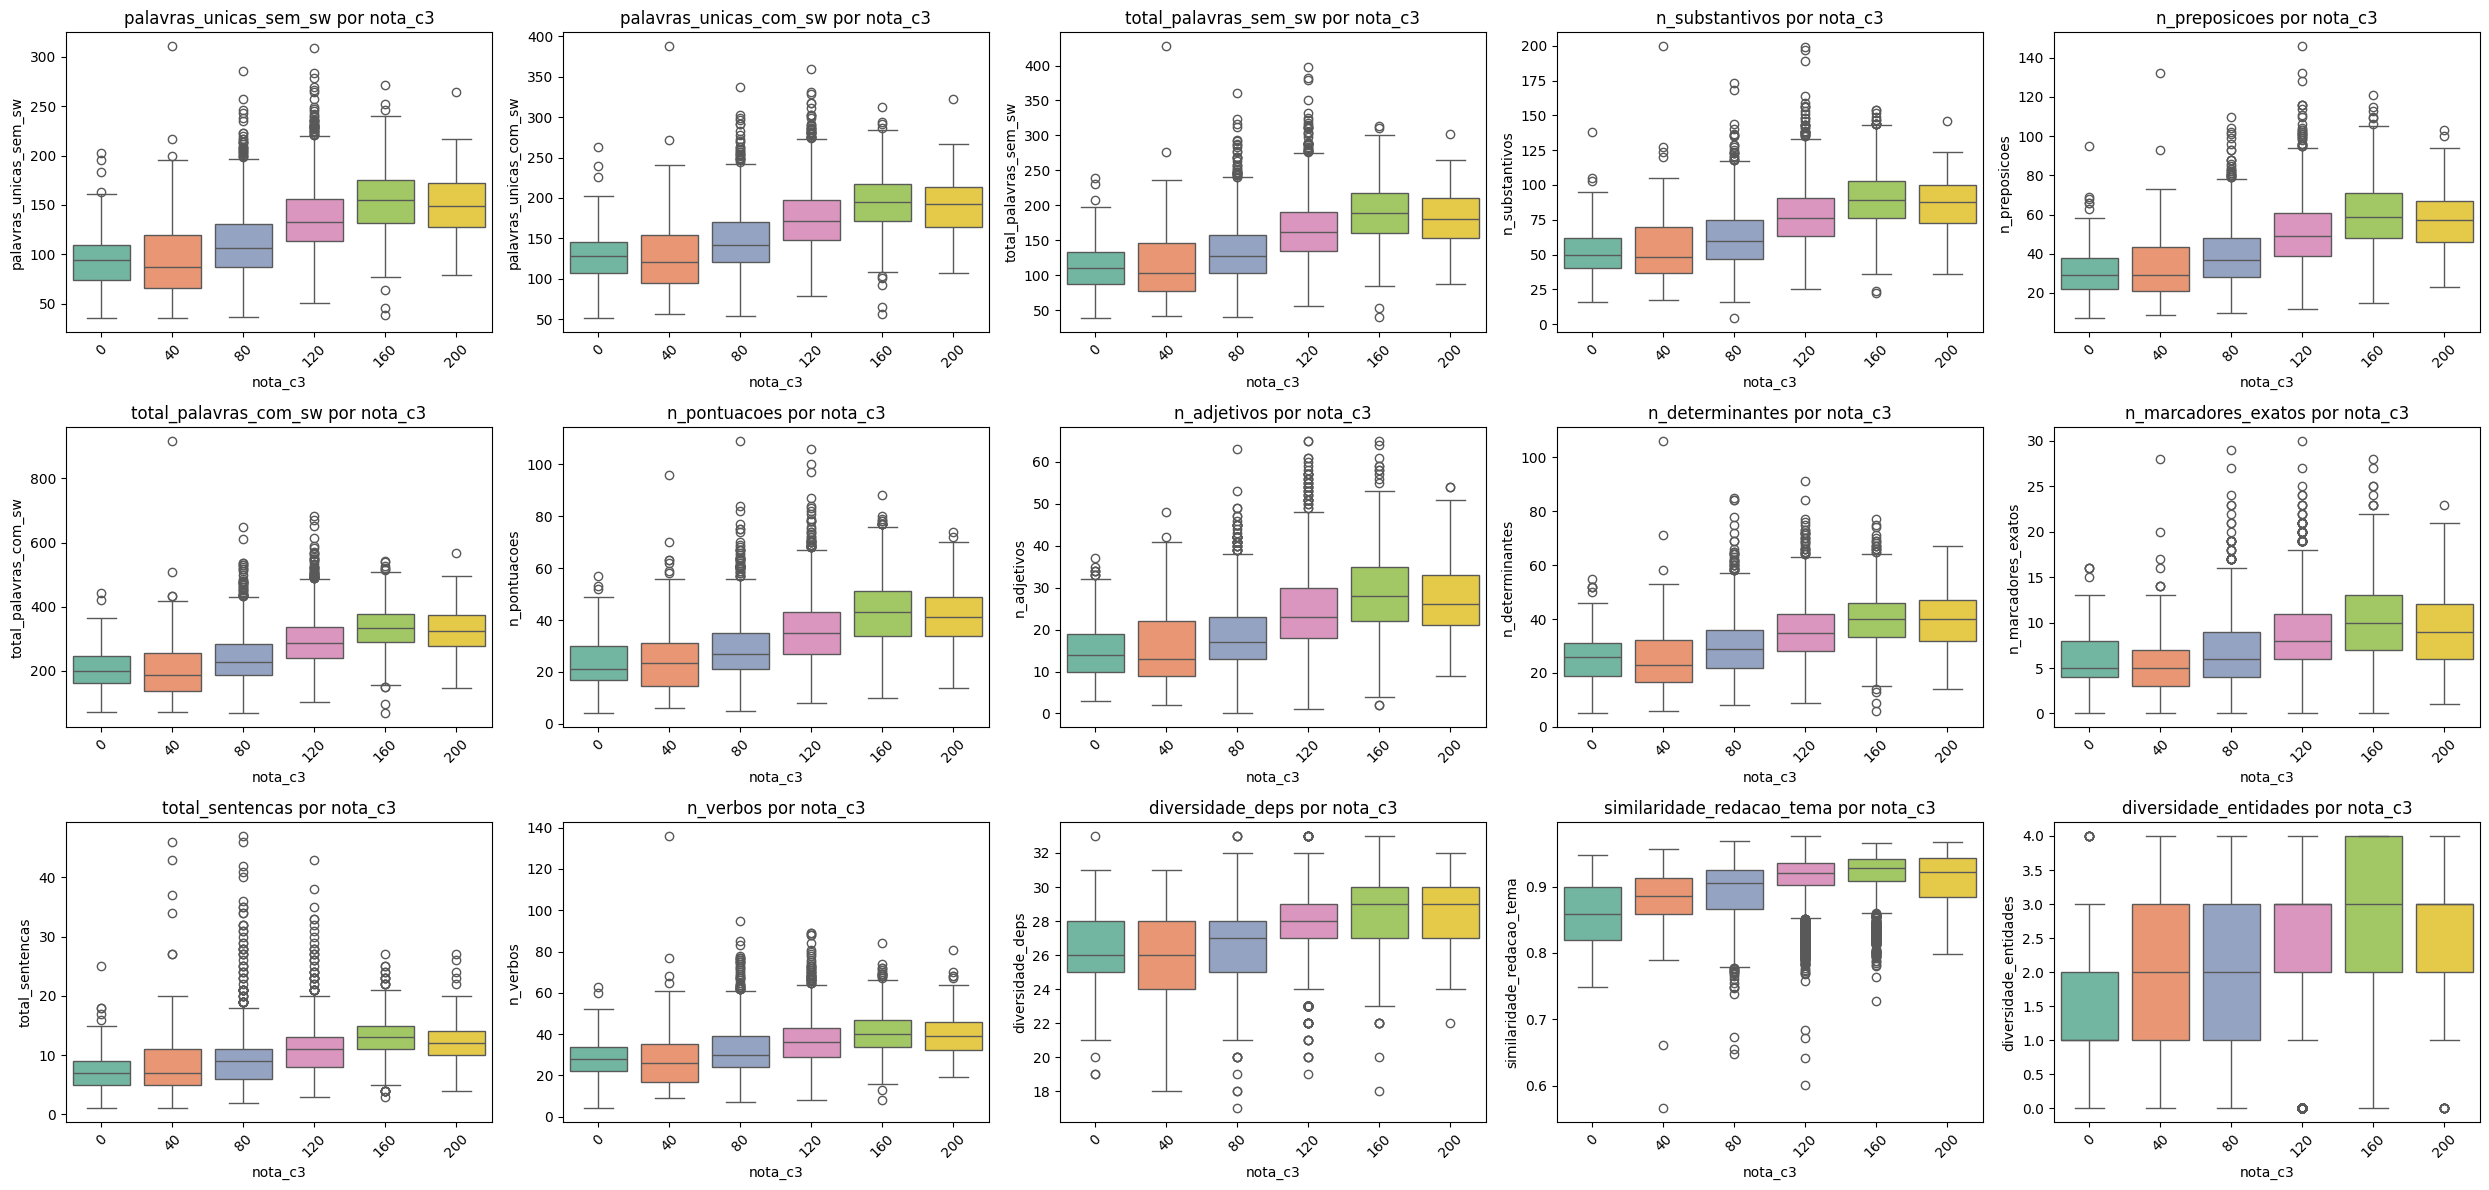

/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2845875067.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtrado, x=coluna_nota, y=col, ax=axes[i], palette='Set2')
/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2845875067.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtrado, x=coluna_nota, y=col, ax=axes[i], palette='Set2')
/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2845875067.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtrado, x=colu

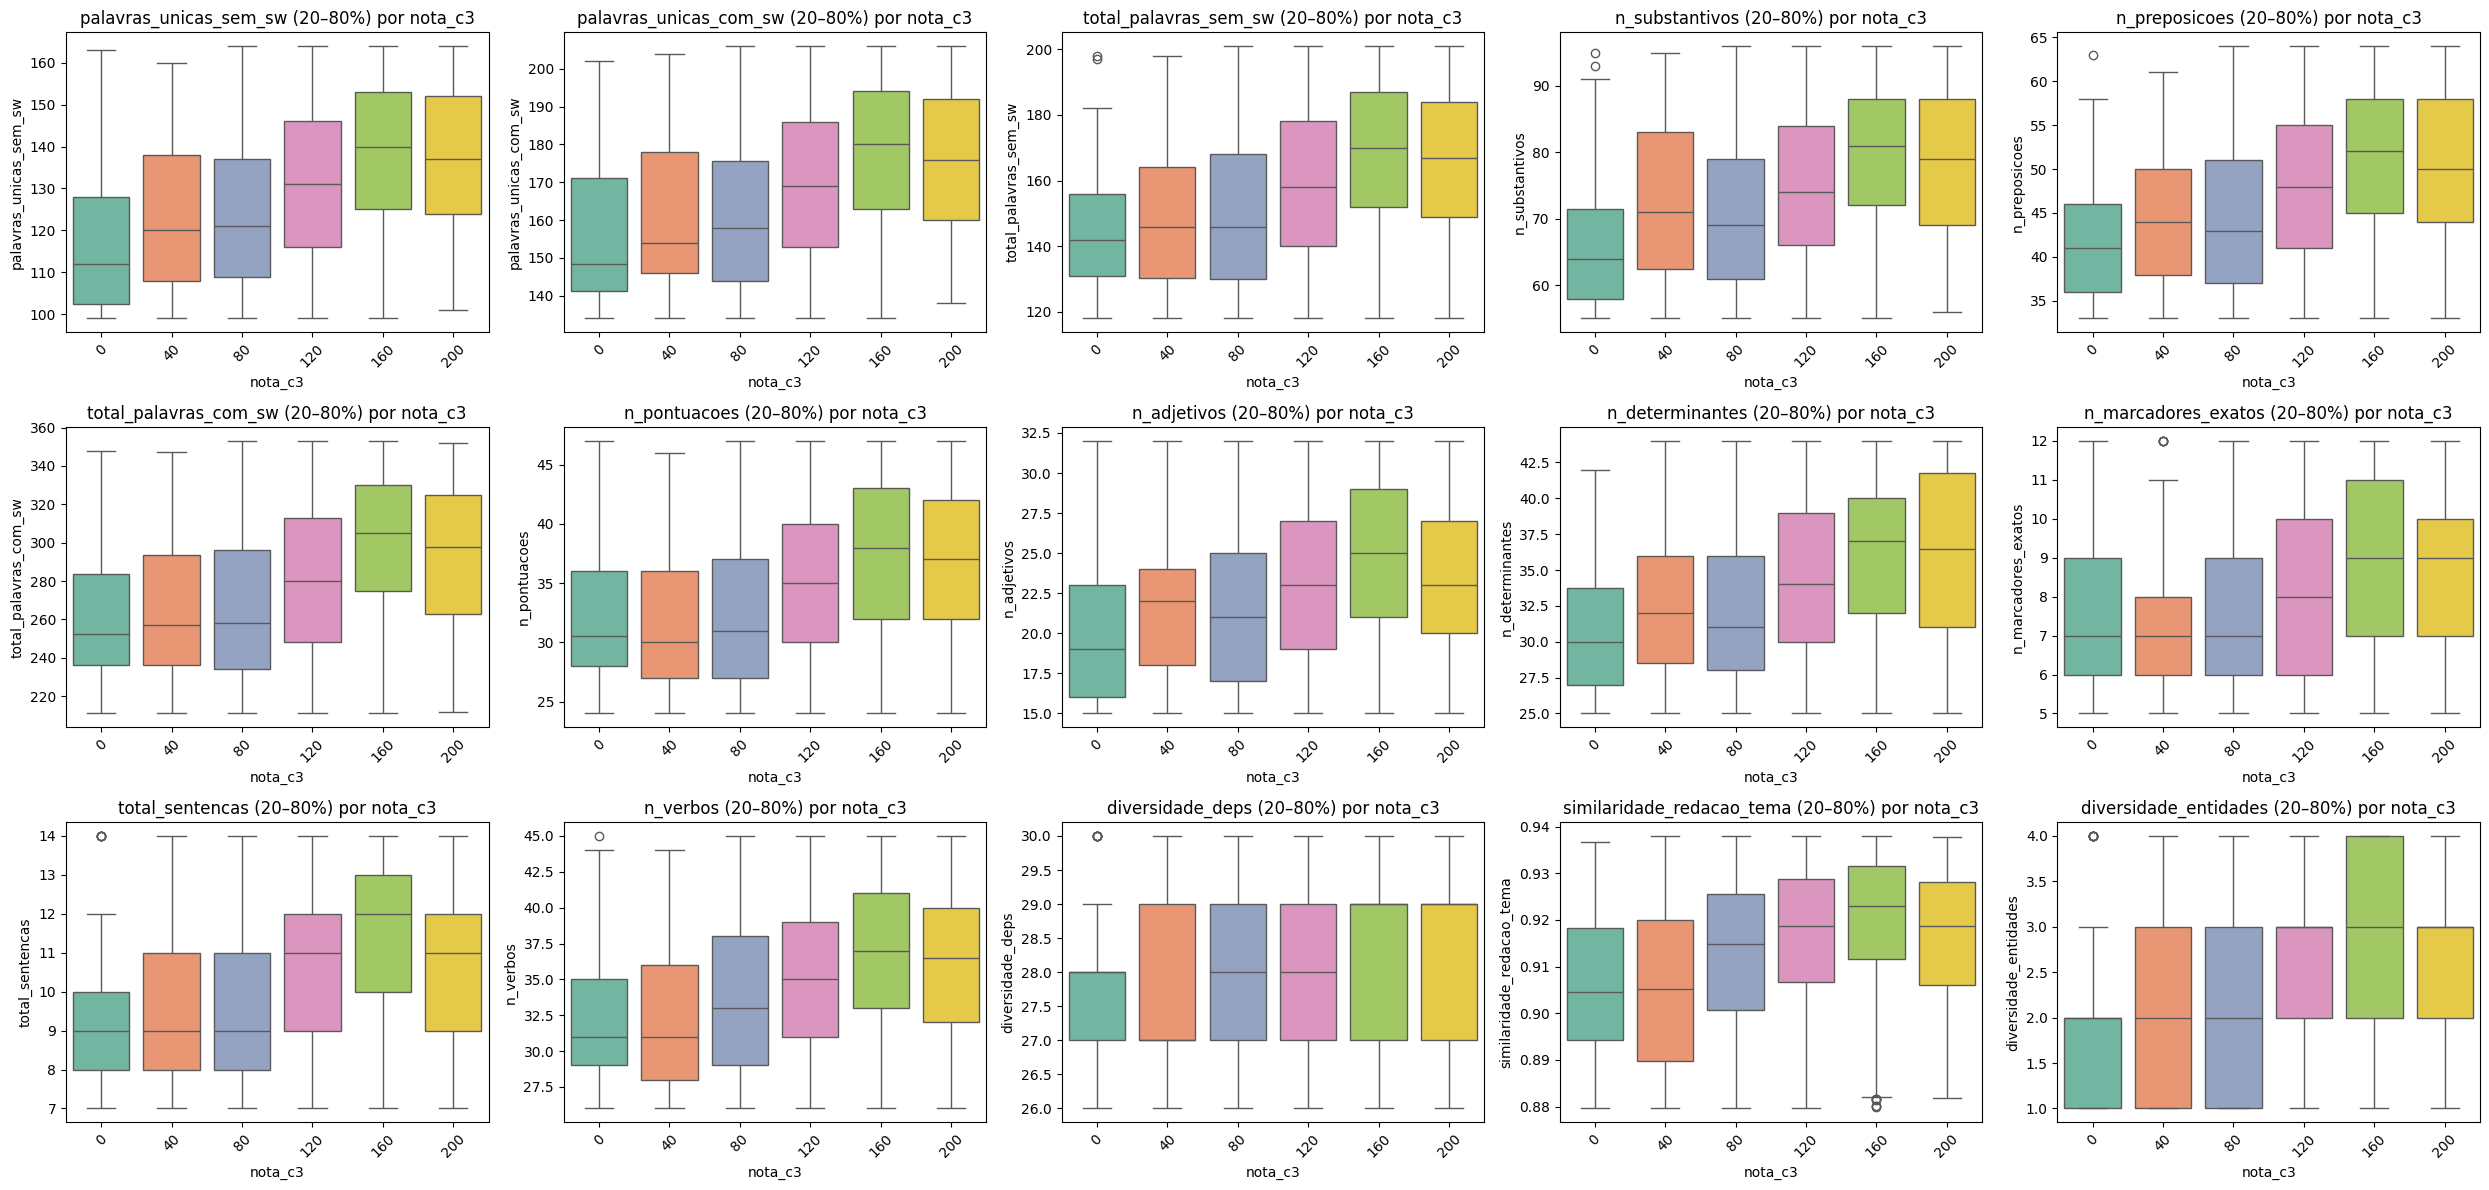


previsoes usando modelo de regras - teste
métricas de classificação
acurácia: 0.3063
quadratic weighted kappa (QWK): 0.3943
precisão (macro): 0.2349
recall (macro): 0.2785
f1-score (macro): 0.2197

 métricas de magnitude do erro
MAE (Erro Absoluto Médio): 40.1623 pontos de nota
RMSE (Raiz do Erro Quadrático Médio): 53.4110 pontos de nota

relatório de classificação:
              precision    recall  f1-score   support

           0       0.10      0.25      0.14        28
          40       0.04      0.33      0.08        24
          80       0.30      0.15      0.20       241
         120       0.55      0.33      0.41       458
         160       0.37      0.46      0.41       207
         200       0.05      0.14      0.08        28

    accuracy                           0.31       986
   macro avg       0.23      0.28      0.22       986
weighted avg       0.41      0.31      0.33       986


previsoes usando modelo de regras - validacao
métricas de classificação
acurácia: 0.29

In [ ]:
# abordagem 3 -> prever nota usando conjunto de regras baseadas nas 10 features com maior correlação

X_analise = df_aux_analise.drop(columns = 'nota_c3')
y_analise = df_aux_analise['nota_c3']


boxplots_por_nota(df_aux_analise)
boxplots_por_nota_faixa_20_80(df_aux_analise)


train_size = 0.70
val_size = 0.15
test_size = 0.15


X_train_regras, X_temp_regras, y_train_regras, y_temp_regras = train_test_split(X_analise, y_analise, train_size = train_size, random_state = 42, stratify = y_analise)

val_test_split_ratio = test_size / (val_size + test_size)

X_val_regras, X_test_regras, y_val_regras, y_test_regras = train_test_split(
    X_temp_regras, y_temp_regras, test_size = val_test_split_ratio, stratify = y_temp_regras, random_state = 42
)



df_treino_completo = X_train_regras.copy()
df_treino_completo['nota_c3'] = y_train_regras

perfis = criar_perfis_de_classe(df_treino_completo, 'nota_c3')
previsoes = X_test_regras.apply(prever_com_regras, axis = 1, perfis_de_classe = perfis)

print("\nprevisoes usando modelo de regras - teste")
acuracia = accuracy_score(y_test_regras, previsoes)
qw_kappa = cohen_kappa_score(y_test_regras, previsoes, weights='quadratic')

mae = mean_absolute_error(y_test_regras, previsoes)
rmse = np.sqrt(mean_squared_error(y_test_regras, previsoes))
print("métricas de classificação")
print(f"acurácia: {acuracia:.4f}")
print(f"quadratic weighted kappa (QWK): {qw_kappa:.4f}")
print(f"precisão (macro): {precision_score(y_test_regras, previsoes, average='macro'):.4f}")
print(f"recall (macro): {recall_score(y_test_regras, previsoes, average='macro'):.4f}")
print(f"f1-score (macro): {f1_score(y_test_regras, previsoes, average='macro'):.4f}")

print("\n métricas de magnitude do erro")
print(f"MAE (Erro Absoluto Médio): {mae:.4f} pontos de nota")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f} pontos de nota")

report = classification_report(
    y_test_regras, 
    previsoes, 
    zero_division = 0
)
print("\nrelatório de classificação:")
print(report)


# para validação
previsoes_v = X_val_regras.apply(prever_com_regras, axis = 1, perfis_de_classe = perfis)


print("\nprevisoes usando modelo de regras - validacao")
acuracia = accuracy_score(y_val_regras, previsoes_v)
qw_kappa = cohen_kappa_score(y_val_regras, previsoes_v, weights='quadratic')
mae = mean_absolute_error(y_val_regras, previsoes_v)
rmse = np.sqrt(mean_squared_error(y_val_regras, previsoes_v))
print("métricas de classificação")
print(f"acurácia: {acuracia:.4f}")
print(f"quadratic weighted kappa (QWK): {qw_kappa:.4f}")
print(f"precisão (macro): {precision_score(y_val_regras, previsoes_v, average='macro'):.4f}")
print(f"recall (macro): {recall_score(y_val_regras, previsoes_v, average='macro'):.4f}")
print(f"f1-score (macro): {f1_score(y_val_regras, previsoes_v, average='macro'):.4f}")

print("\n métricas de magnitude do erro")
print(f"MAE (Erro Absoluto Médio): {mae:.4f} pontos de nota")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f} pontos de nota")

report = classification_report(
    y_val_regras, 
    previsoes_v, 
    zero_division = 0
)
print("\nrelatório de classificação:")
print(report)

### Abordagem 4: Predição com Regras Baseadas em Todas as Features

Nesta abordagem, é utilizado um modelo de regras simples para prever a nota C3, mas agora considerando **todas as features disponíveis** no conjunto de dados.

Primeiro, os dados são divididos em treino (70%), validação (15%) e teste (15%) com estratificação da variável-alvo. A função `criar_perfis_de_classe` é aplicada sobre o conjunto de treino completo para gerar, para cada nota, os intervalos percentílicos (20% e 80%) de cada feature, definindo assim o perfil típico de cada classe.

A função `prever_com_regras` é então usada para prever a nota das redações com base no número de características que se encaixam nas faixas percentílicas de cada perfil.

A seguir, as predições são avaliadas nos conjuntos de teste e validação por meio das métricas:
- Acurácia
- Quadratic Weighted Kappa (QWK)
- Erro Absoluto Médio (MAE)
- Raiz do Erro Quadrático Médio (RMSE)


/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2105048185.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=coluna_nota, y=col, ax=axes[i], palette='Set2')
/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2105048185.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=coluna_nota, y=col, ax=axes[i], palette='Set2')
/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2105048185.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=coluna_nota, y=col, ax=axes[i],

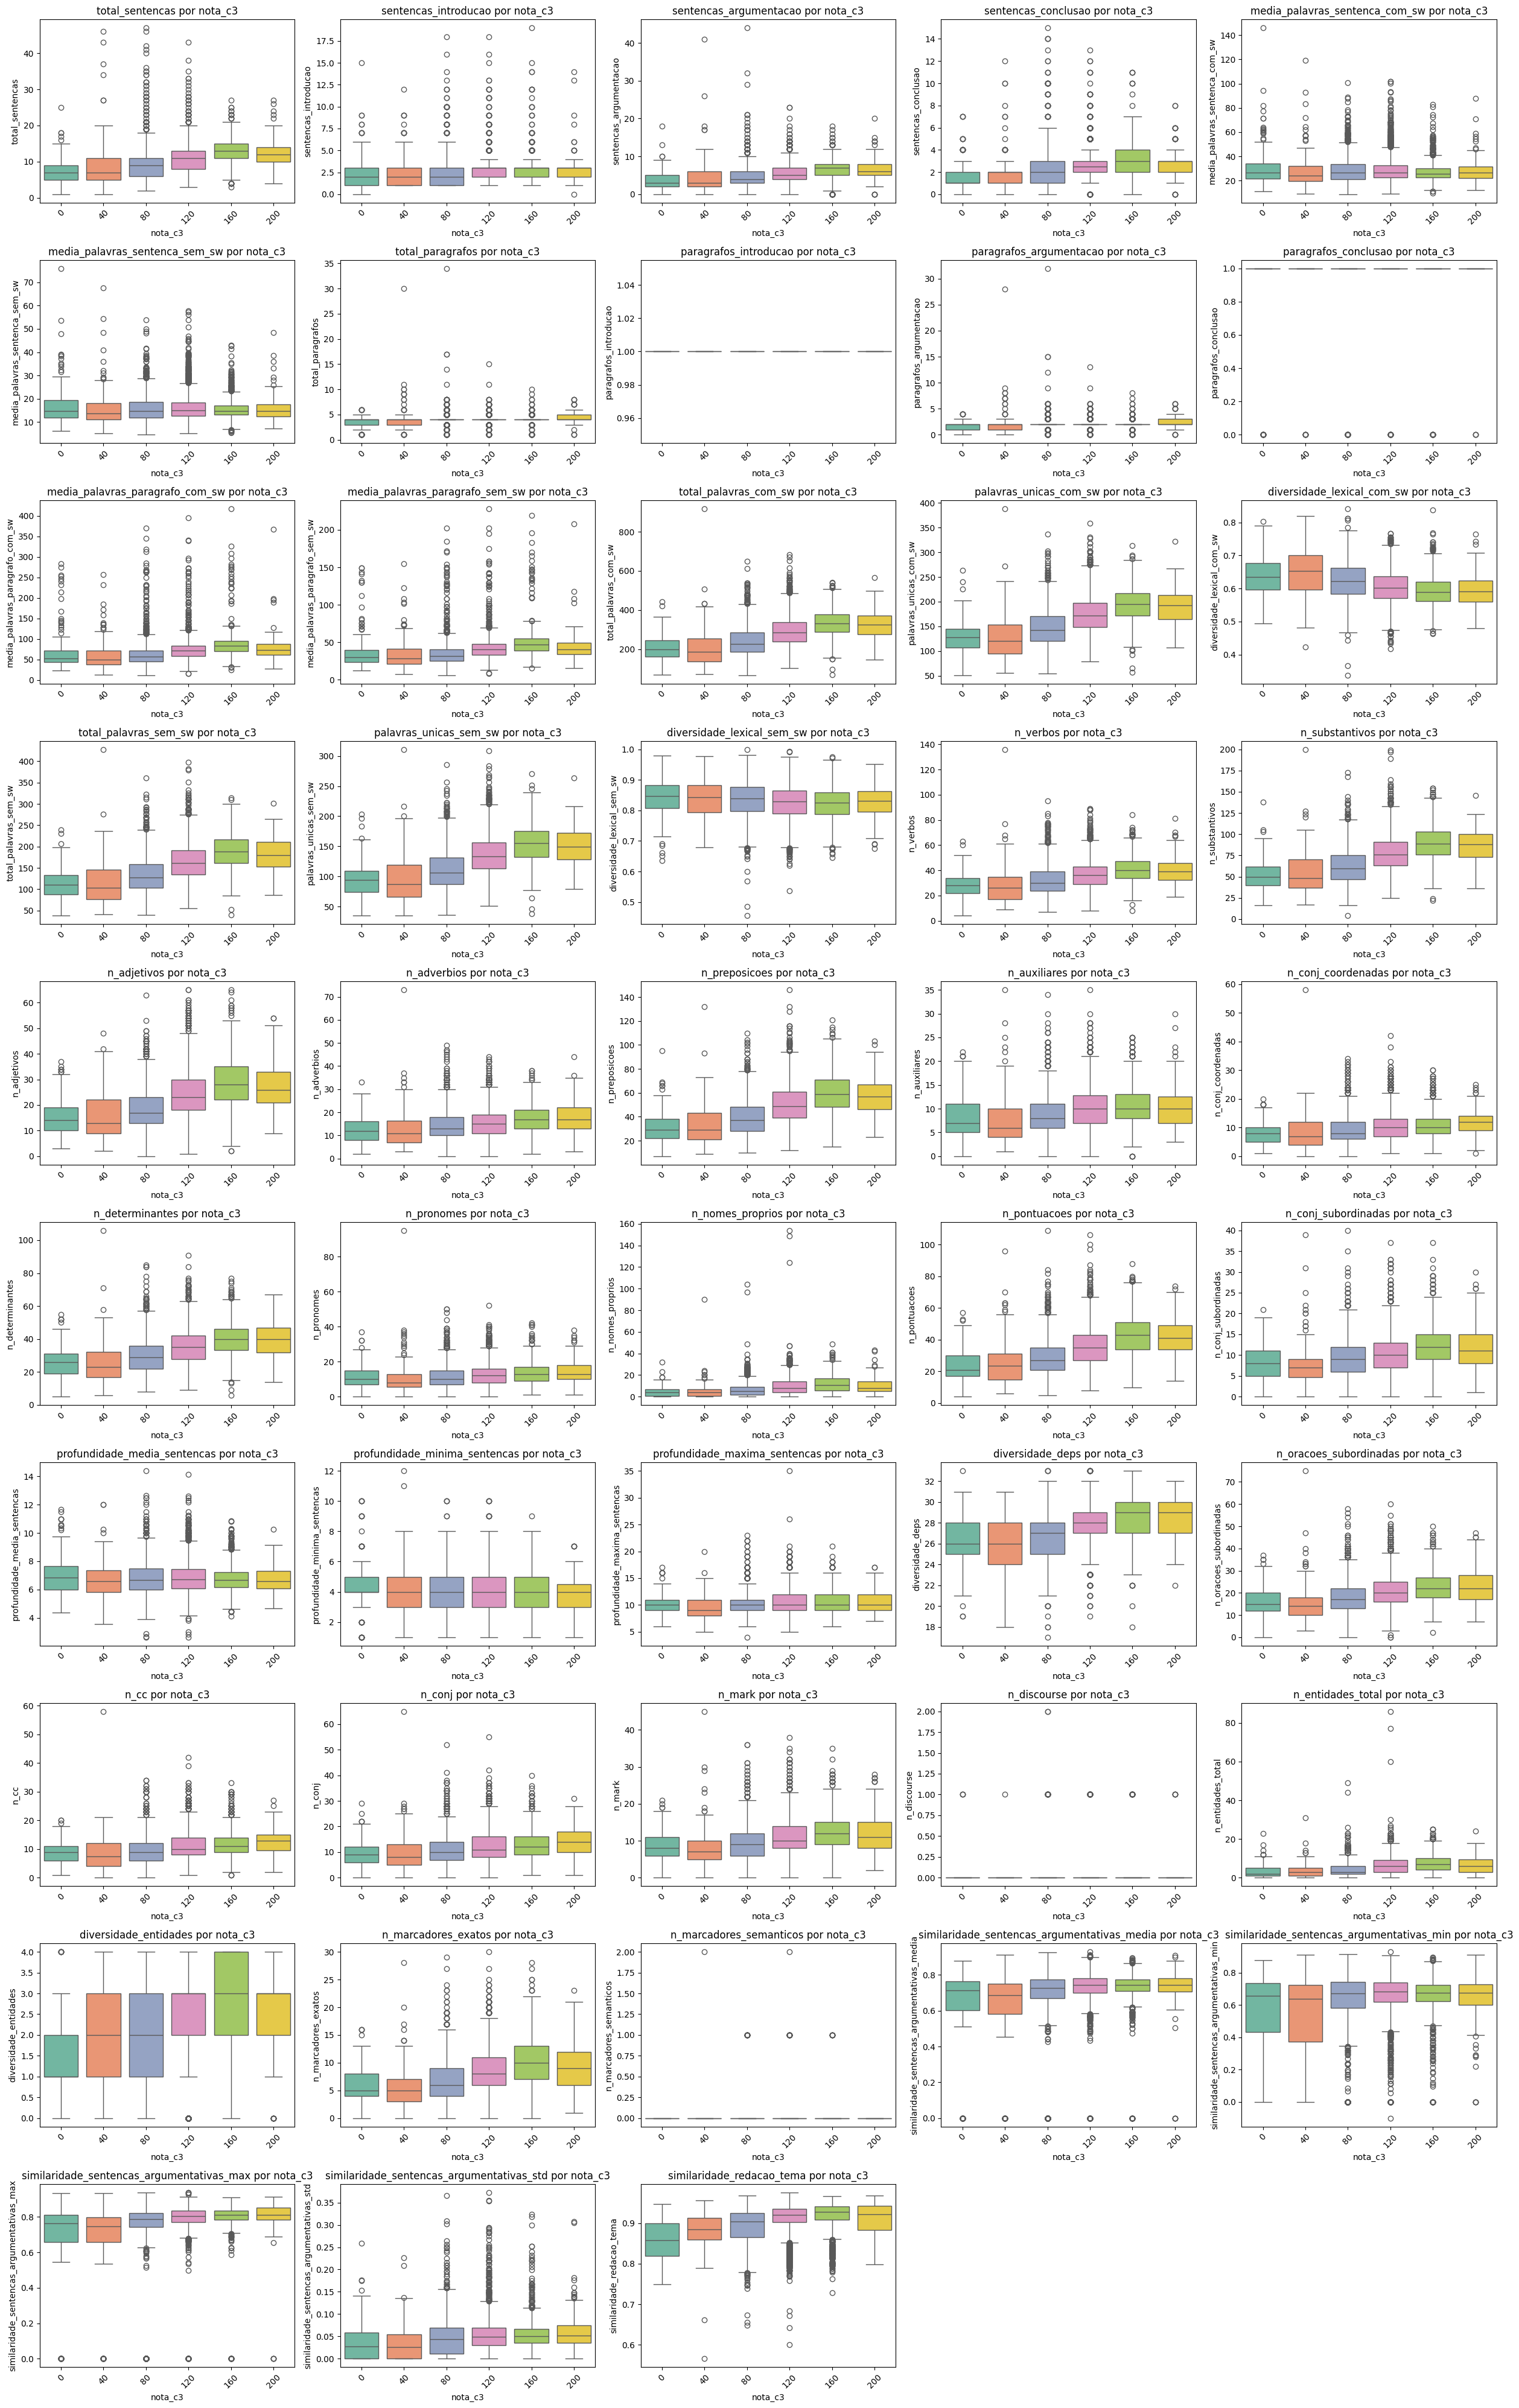

/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2845875067.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtrado, x=coluna_nota, y=col, ax=axes[i], palette='Set2')
/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2845875067.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtrado, x=coluna_nota, y=col, ax=axes[i], palette='Set2')
/var/folders/zp/v45jrsp9623fpv18zjp1t3kr0000gq/T/ipykernel_11872/2845875067.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtrado, x=colu

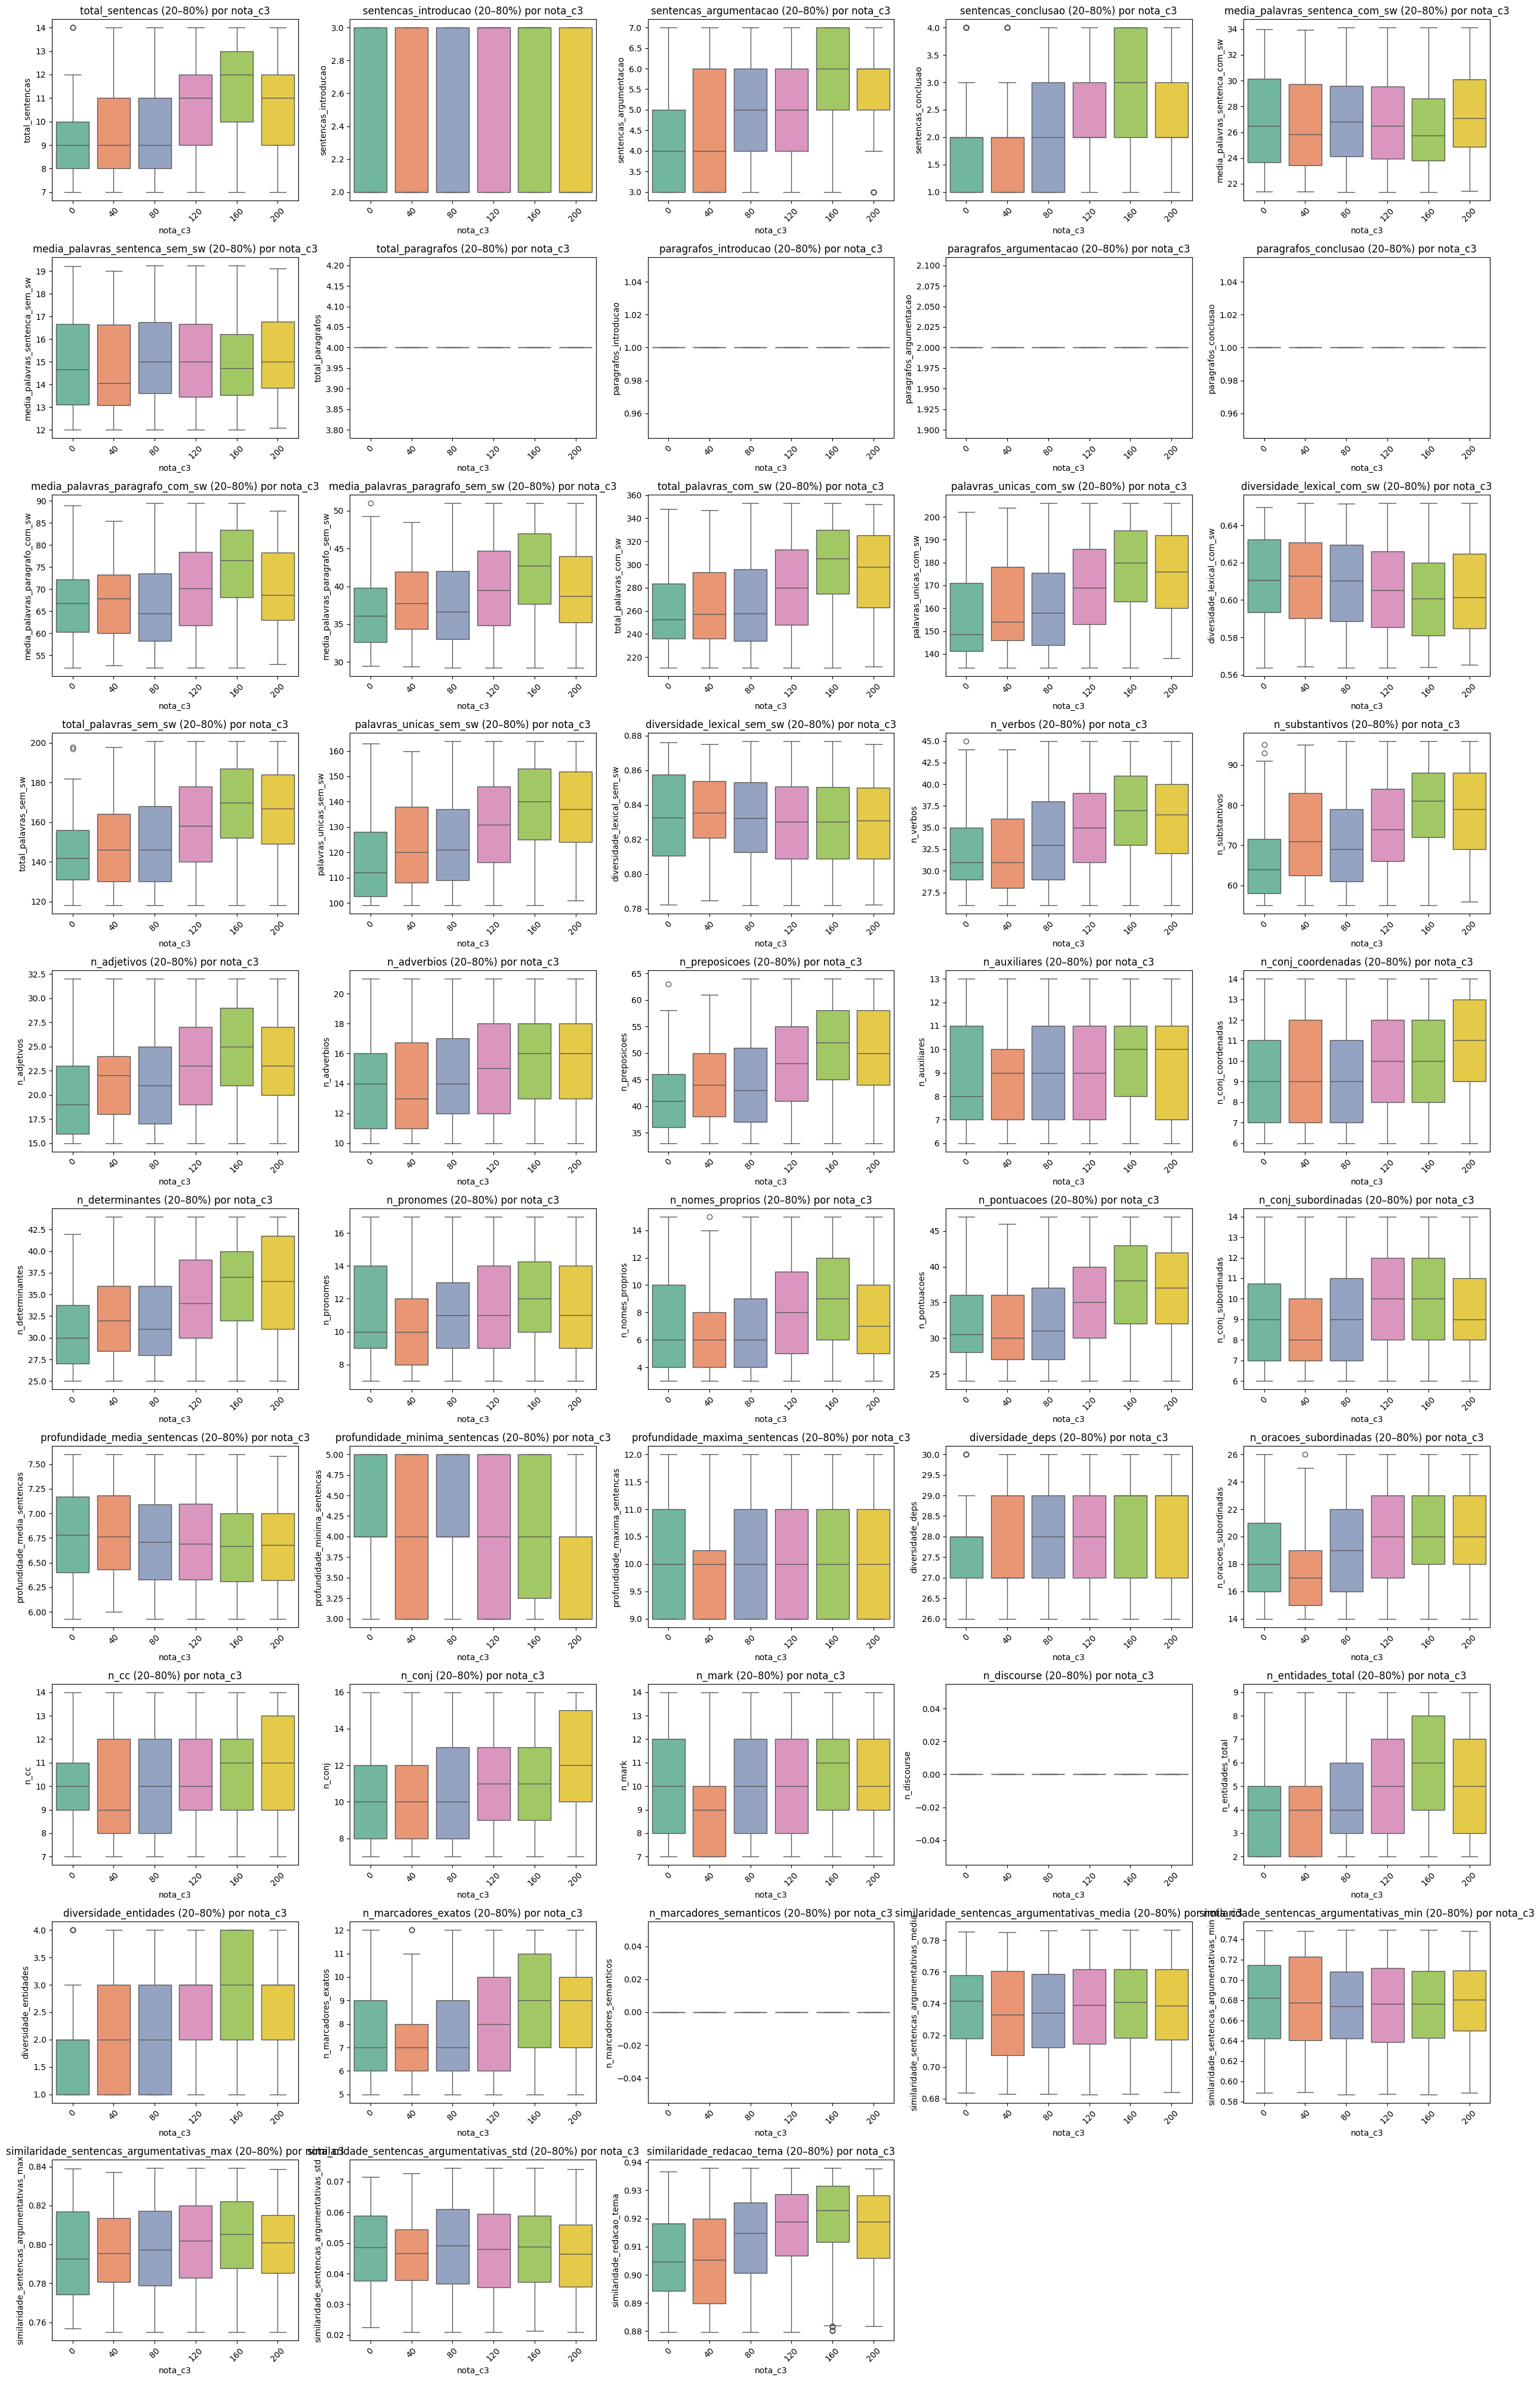


previsoes usando modelo de regras - teste
métricas de classificação
acurácia: 0.2748
quadratic weighted kappa (QWK): 0.3935
precisão (macro): 0.2383
recall (macro): 0.2999
f1-score (macro): 0.2154

 métricas de magnitude do erro
MAE (Erro Absoluto Médio): 41.7444 pontos de nota
RMSE (Raiz do Erro Quadrático Médio): 53.8799 pontos de nota

relatório de classificação:
              precision    recall  f1-score   support

           0       0.08      0.11      0.09        28
          40       0.05      0.46      0.09        24
          80       0.24      0.20      0.22       241
         120       0.56      0.26      0.35       458
         160       0.41      0.39      0.40       207
         200       0.08      0.39      0.14        28

    accuracy                           0.27       986
   macro avg       0.24      0.30      0.22       986
weighted avg       0.41      0.27      0.31       986


previsoes usando modelo de regras - validacao
métricas de classificação
acurácia: 0.27

In [58]:
# abordagem 4 -> prever nota usando conjunto de regras baseadas em todas as features

df_aux_analise2 = df_resultado.drop(columns = ['projeto_texto', 'id_redacao'])

boxplots_por_nota(df_aux_analise2)
boxplots_por_nota_faixa_20_80(df_aux_analise2)

X_analise2 = df_aux_analise2.drop(columns = 'nota_c3')
y_analise2 = df_aux_analise2['nota_c3']

train_size = 0.70
val_size = 0.15
test_size = 0.15


X_train_regras, X_temp_regras, y_train_regras, y_temp_regras = train_test_split(X_analise2, y_analise2, train_size = train_size, random_state = 42, stratify = y_analise2)

val_test_split_ratio = test_size / (val_size + test_size)

X_val_regras, X_test_regras, y_val_regras, y_test_regras = train_test_split(
    X_temp_regras, y_temp_regras, test_size = val_test_split_ratio, stratify = y_temp_regras, random_state = 42
)

df_treino_completo = X_train_regras.copy()
df_treino_completo['nota_c3'] = y_train_regras

perfis = criar_perfis_de_classe(df_treino_completo, 'nota_c3')
previsoes = X_test_regras.apply(prever_com_regras, axis = 1, perfis_de_classe = perfis)

print("\nprevisoes usando modelo de regras - teste")
acuracia = accuracy_score(y_test_regras, previsoes)
qw_kappa = cohen_kappa_score(y_test_regras, previsoes, weights='quadratic')
mae = mean_absolute_error(y_test_regras, previsoes)
rmse = np.sqrt(mean_squared_error(y_test_regras, previsoes))
print("métricas de classificação")
print(f"acurácia: {acuracia:.4f}")
print(f"quadratic weighted kappa (QWK): {qw_kappa:.4f}")
print(f"precisão (macro): {precision_score(y_test_regras, previsoes, average='macro'):.4f}")
print(f"recall (macro): {recall_score(y_test_regras, previsoes, average='macro'):.4f}")
print(f"f1-score (macro): {f1_score(y_test_regras, previsoes, average='macro'):.4f}")


print("\n métricas de magnitude do erro")
print(f"MAE (Erro Absoluto Médio): {mae:.4f} pontos de nota")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f} pontos de nota")

report = classification_report(
    y_test_regras, 
    previsoes, 
    zero_division = 0
)
print("\nrelatório de classificação:")
print(report)


# para validação
previsoes_v = X_val_regras.apply(prever_com_regras, axis = 1, perfis_de_classe = perfis)


print("\nprevisoes usando modelo de regras - validacao")
acuracia = accuracy_score(y_val_regras, previsoes_v)
qw_kappa = cohen_kappa_score(y_val_regras, previsoes_v, weights='quadratic')
mae = mean_absolute_error(y_val_regras, previsoes_v)
rmse = np.sqrt(mean_squared_error(y_val_regras, previsoes_v))
print("métricas de classificação")
print(f"acurácia: {acuracia:.4f}")
print(f"quadratic weighted kappa (QWK): {qw_kappa:.4f}")
print(f"precisão (macro): {precision_score(y_val_regras, previsoes_v, average='macro'):.4f}")
print(f"recall (macro): {recall_score(y_val_regras, previsoes_v, average='macro'):.4f}")
print(f"f1-score (macro): {f1_score(y_val_regras, previsoes_v, average='macro'):.4f}")


print("\n métricas de magnitude do erro")
print(f"MAE (Erro Absoluto Médio): {mae:.4f} pontos de nota")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f} pontos de nota")

report = classification_report(
    y_val_regras, 
    previsoes_v, 
    zero_division = 0
)
print("\nrelatório de classificação:")
print(report)
